# Behavior of simple model with varying wind and solar cost
In the following document, we want to find the behavior of a simple solar/wind/natural gas system when varying first by solar cost, and then by wind cost. While varying solar, we set a wind cost (onshore) of 1118 EUR/KW and a gas cost of 453 EUR/KW. While varying wind, we set a solar cost (utility) of 529 EUR/MW and the same gas cost.


# Table of Contents:
1. [Preliminary](#section-one)
    1. [Carriers, Generators, wind and solar loading](#subsection-one)
2. [Variation of solar cost](#section-two)
    1. [Running the optimization](#sub2.1)
    2. [Graph of penetration](#sub2.2)
    3. [Graph of system cost](#sub2.3)
    4. [Graph of curtailment percent](#sub2.4)
3. [Variation of wind cost](#section-three)
    1. [Running the optimization](#sub3.1)
    2. [Graph of penetration](#sub3.2)
    3. [Graph of system cost](#sub3.3)
    4. [Graph of curtailment percent](#sub3.4)
4. [Variation of gas cost](#section-four)
    1. [Running the optimization](#sub4.1)
    2. [Graph of penetration](#sub4.2)
    3. [Graph of system cost](#sub4.3)
    4. [Graph of curtailment percent](#sub4.4)
5. [Mismatch of renewables](#section-five)
    1. [Solar mismatch](#sub5.1)
    2. [Wind mismatch](#sub5.2)
        

## 1. Preliminary <a name="section-one"></a>

In [1]:
import pypsa
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import repeat

In [2]:
start = time.time()
#network = Denmark, nspain, ncal, ncolorado
network = pypsa.Network()
nspain = pypsa.Network()
ncal = pypsa.Network()
nco = pypsa.Network()


hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H') #for network, nspain
hours_in_2011 = pd.date_range('2011-01-01T00:00:00','2011-12-31T23:00:00', freq='H') #for ncal, nco


network.set_snapshots(hours_in_2015)
nspain.set_snapshots(hours_in_2015)
ncal.set_snapshots(hours_in_2011)
nco.set_snapshots(hours_in_2011)


network.add("Bus","electricity bus")
nspain.add("Bus","electricity bus")
ncal.add("Bus","electricity bus")
nco.add("Bus","electricity bus")
#network.snapshots
end = time.time()
print(end-start)

8.885223865509033


In [3]:
# load electricity demand data

#for network, nspain
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0)# in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

df_cal_elec = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_elec.index = pd.to_datetime(df_cal_elec.index)

df_co_elec = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_elec.index = pd.to_datetime(df_co_elec.index)
#print(df_elec['DNK'].head())

In [4]:
# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['DNK'])

nspain.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['ESP'])

ncal.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_cal_elec['demand_mwh'])

nco.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_co_elec['demand_mwh'])

In [5]:
#network.loads_t.p_set
#nspain.loads_t.p_set
#ncal.loads_t.p_set
#nco.loads_t.p_set

In [6]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

The above is everything that that has been done in the jupyter notebook of the project given to us. At this point, we want to vary the cost of the solar below, with everything else remaining constant, and plot what happens.

### 1.1 Carriers, generators, wind and solar loading <a name="subsection-one"></a> 
Taking overnight investment cost, lifetime, and fixed operation and maintenance cost from https://github.com/PyPSA/technology-data/blob/master/latex_tables/tables_in_latex.pdf

Annualized cost = annuity (lifetime, discount rate) * overnight investment cost * fixed O&M cost (%).

Let's have three generators, solar, onshore wind, gas

In [7]:
start = time.time()
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

nspain.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
nspain.add("Carrier", "onshorewind")
nspain.add("Carrier", "solar")

ncal.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
ncal.add("Carrier", "onshorewind")
ncal.add("Carrier", "solar")

nco.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
nco.add("Carrier", "onshorewind")
nco.add("Carrier", "solar")



# add onshore wind data for DNK and ESP
df_onshorewind = pd.read_csv('data_extra/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_cal_onshorewind = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_onshorewind.index = pd.to_datetime(df_cal_onshorewind.index)

df_co_onshorewind = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_onshorewind.index = pd.to_datetime(df_co_onshorewind.index)

#Capacity factors for denmark and spain, then adding wind generators for denmark and spain
CF_wind = df_onshorewind['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CFw_spain = df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in nspain.snapshots]]
CFw_cal = df_cal_onshorewind['onwind'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in ncal.snapshots]]
CFw_co = df_co_onshorewind['onwind'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in nco.snapshots]]

capital_cost_onshorewind = annuity(27,0.07)*1118000*(1+0.012) #EUR/MW

network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

nspain.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CFw_spain)

ncal.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CFw_cal)

nco.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CFw_co)


#Add solar data for DNK and ESP
df_solar = pd.read_csv('data_extra/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

df_cal_solar = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_solar.index = pd.to_datetime(df_cal_solar.index)

df_co_solar = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_solar.index = pd.to_datetime(df_co_solar.index)

#Capacity factors (solar) for denmark and spain, then adding solar generators for denmark and spain
CF_solar = df_solar['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CFs_spain = df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in nspain.snapshots]]

CFs_cal = df_cal_solar['solar'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in ncal.snapshots]]

CFs_co = df_co_solar['solar'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in nco.snapshots]]

#utility scale solar
capital_cost_solar = annuity(35,0.07)*529000*(1+0.016)

network.add("Generator",
        "solar",
        bus="electricity bus",
        p_nom_extendable=True,
        carrier="solar",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_solar,
        marginal_cost = 0,
        p_max_pu = CF_solar)


nspain.add("Generator",
        "solar",
        bus="electricity bus",
        p_nom_extendable=True,
        carrier="solar",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_solar,
        marginal_cost = 0,
        p_max_pu = CFs_spain)

ncal.add("Generator",
        "solar",
        bus="electricity bus",
        p_nom_extendable=True,
        carrier="solar",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_solar,
        marginal_cost = 0,
        p_max_pu = CFs_cal)


nco.add("Generator",
        "solar",
        bus="electricity bus",
        p_nom_extendable=True,
        carrier="solar",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_solar,
        marginal_cost = 0,
        p_max_pu = CFs_co)


#For gas, we assume the same cost in all countries. we just need to add a generator to each network,
# network, nspain, etc
capital_cost_OCGT = annuity(25,0.07)*453000*(1+0.018) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el

network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

nspain.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

ncal.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

nco.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

end = time.time()
print(end-start)

7.958528995513916


## 2. Variation by solar cost <a name="section-two"></a>

### 2.1 Running the optimization <a name="sub2.1"></a>
The following sections create a list of system characteristics vs solar cost, and then plots it, for DNK, ESP, CAL, CO

We are trying to find behaviors at both small and large numbers. We need numbers above 500000 because that is where the real cost of solar lies. However, in our model, solar gets squeezed out really quickly. Plus we are more interested at what happens in cheaper scenarios anyway. This is the reason that we use a logspace instead of a linspace for our optimizations and our graph. 

Before we start the optimization, let's take a moment to reset our stats for cost in case they changed

In [8]:
def reset_stats(n):
    n.generators.loc[['solar'], ['capital_cost']] = annuity(35,0.07)*529000*(1+0.016)
    n.generators.loc[['onshorewind'], ['capital_cost']] = annuity(27,0.07)*1118000*(1+0.012)
    n.generators.loc[['OCGT'], ['capital_cost']] = capital_cost_OCGT = annuity(25,0.07)*453000*(1+0.018)


In [11]:
#Next step: I want to return a tuple that gives me solar, wind, and gas penetrations

def find_solar_data(n, solar_cost):
    #Takes annualized coefficient and multiplies by investment cost
    annualized_solar_cost =  0.07846970300338728* solar_cost
    n.generators.loc[['solar'],['capital_cost']] = annualized_solar_cost
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    
    solar_penetration = n.generators_t.p['solar'].sum()/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement###
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    ###You can delete the code above if you wish###
    
    
    return (solar_penetration, wind_penetration, gas_penetration, systemcost, curtailment)





#These four below return 100 points of cost vs solar penetration. 
reset_stats(network)
reset_stats(nspain)
reset_stats(ncal)
reset_stats(nco)

# DNK_solar_data = list(map(find_solar_data, repeat(network), np.linspace(50000, 600000, 10)))
# ESP_solar_data = list(map(find_solar_data, repeat(nspain), np.linspace(50000, 600000, 10)))
CAL_solar_data = list(map(find_solar_data, repeat(ncal), np.linspace(50000, 600000, 10)))
CO_solar_data = list(map(find_solar_data, repeat(nco), np.linspace(50000, 600000, 10)))





print(DNK_solar_data)
print(ESP_solar_data)
print(CAL_solar_data)
print(CO_solar_data)




INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.95s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-265m33zr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb9327214
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fwyaapp0.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x2238aa05
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rhrqm4ec.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0ac974ff
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c_jm0yhl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x994b6f28
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v762e91_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x04e25ed7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gn7hkc13.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfddc603c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1gmqn5gb.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6f68b57b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l1m6vtit.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x12a66915
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fz2n4j15.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfaea08f2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ycs780mm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x049745a3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.64e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2kvgaqfg.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x1cb8a60d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.95s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8i2rfuja.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xfcc14409
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.95s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e0bpsg73.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2bb527b5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2la4oi2e.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf1547b27
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fi1vvsji.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd8ad3417
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.82e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-215521qg.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x4a7a0998
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.89e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-37enxj70.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd757a9a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ucvzd8lo.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x32ff8ed7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2okdijaq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x89327b9f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q15awsjm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9e2a2460
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.12e+09


[(0.3613728368596142, 0.23442633565073598, 0.40420082748964975, load    43.954903
dtype: float64, -0.5382284217705656), (0.2991215817701926, 0.2789558510453886, 0.42192256718441873, load    46.863338
dtype: float64, -0.3080592924795857), (0.25925875894498696, 0.3109756528532004, 0.4297655882018126, load    48.718767
dtype: float64, -0.17444561269063355), (0.22612000433731907, 0.33752425521461704, 0.43635574044806386, load    50.113921
dtype: float64, -0.08657835813993232), (0.20121180268857428, 0.3559430353335887, 0.4428451619778371, load    51.261011
dtype: float64, -0.03990102749921538), (0.17723563223751232, 0.37572844942207345, 0.4470359183404142, load    52.235423
dtype: float64, -0.014159269281353118), (0.14854705874057686, 0.39486466846224955, 0.4565882727971735, load    53.069523
dtype: float64, -0.0018484111885607257), (0.11150653923732584, 0.4166400417626173, 0.47185341900005684, load    53.724482
dtype: float64, 1.2137004582453564e-21), (0.07767564936365205, 0.43815880541355

### 2.2 Graph of penetration <a name="sub2.2"></a>
The below piece of code creates the plot for the above lists

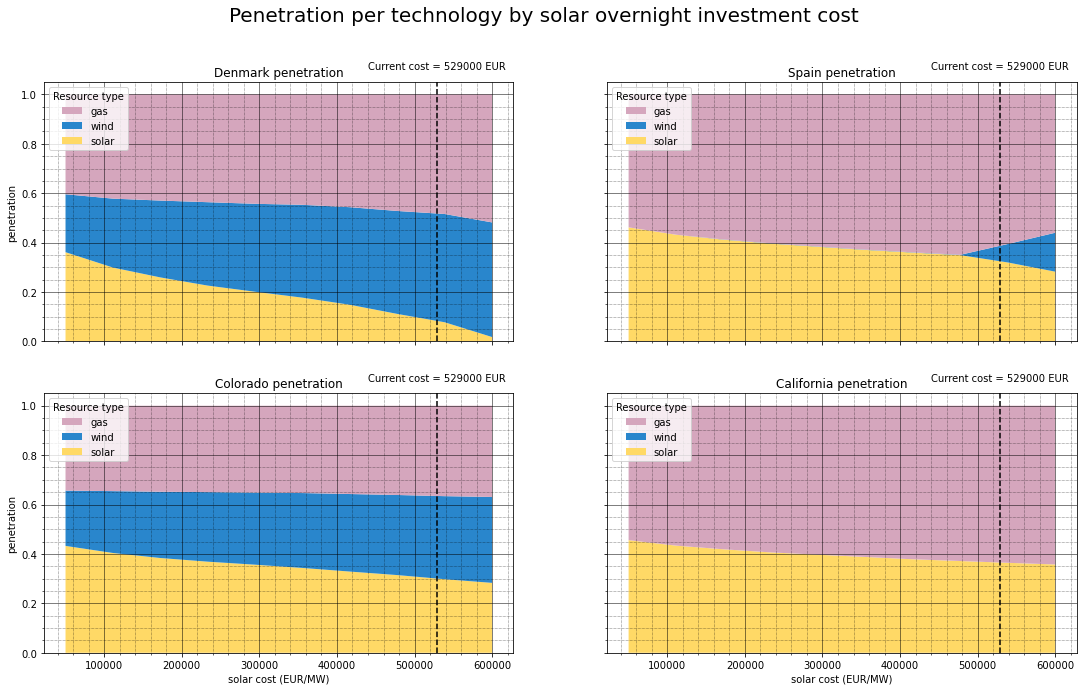

In [12]:
#This is our x axis, solar_cost (s_cost)
s_cost = np.linspace(50000, 600000, 10)

#This is our y axis. sp = solar penetration, wp = wind penetration, gp = gas penetration
DNK_sp = [x[0] for x in DNK_solar_data]
ESP_sp = [x[0] for x in ESP_solar_data]
CAL_sp = [x[0] for x in CAL_solar_data]
CO_sp = [x[0] for x in CO_solar_data]

DNK_wp = [x[1] for x in DNK_solar_data]
ESP_wp = [x[1] for x in ESP_solar_data]
CAL_wp = [x[1] for x in CAL_solar_data]
CO_wp = [x[1] for x in CO_solar_data]

DNK_gp = [x[2] for x in DNK_solar_data]
ESP_gp = [x[2] for x in ESP_solar_data]
CAL_gp = [x[2] for x in CAL_solar_data]
CO_gp = [x[2] for x in CO_solar_data]




fig, axs = plt.subplots(2,2)
axs[0, 0].stackplot(s_cost, DNK_sp, DNK_wp, DNK_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 0].set_title("Denmark penetration")
axs[0, 1].stackplot(s_cost, ESP_sp, ESP_wp, ESP_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 1].set_title("Spain penetration")
axs[1, 0].stackplot(s_cost, CO_sp, CO_wp, CO_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 0].set_title("Colorado penetration")
axs[1, 1].stackplot(s_cost, CAL_sp, CAL_wp, CAL_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 1].set_title("California penetration")



for ax in axs.flat:
    ax.minorticks_on()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Resource type', loc='upper left')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='penetration')
#Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,1.1, "Current cost = 529000 EUR", horizontalalignment = "center")


plt.suptitle("Penetration per technology by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/PenPerTechbySolarCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()




### 2.3 Graph of system cost <a name="sub2.3"></a>
At this point, it is important to calculate the total system cost vs the price of solar. The following is the graph to plot the cost

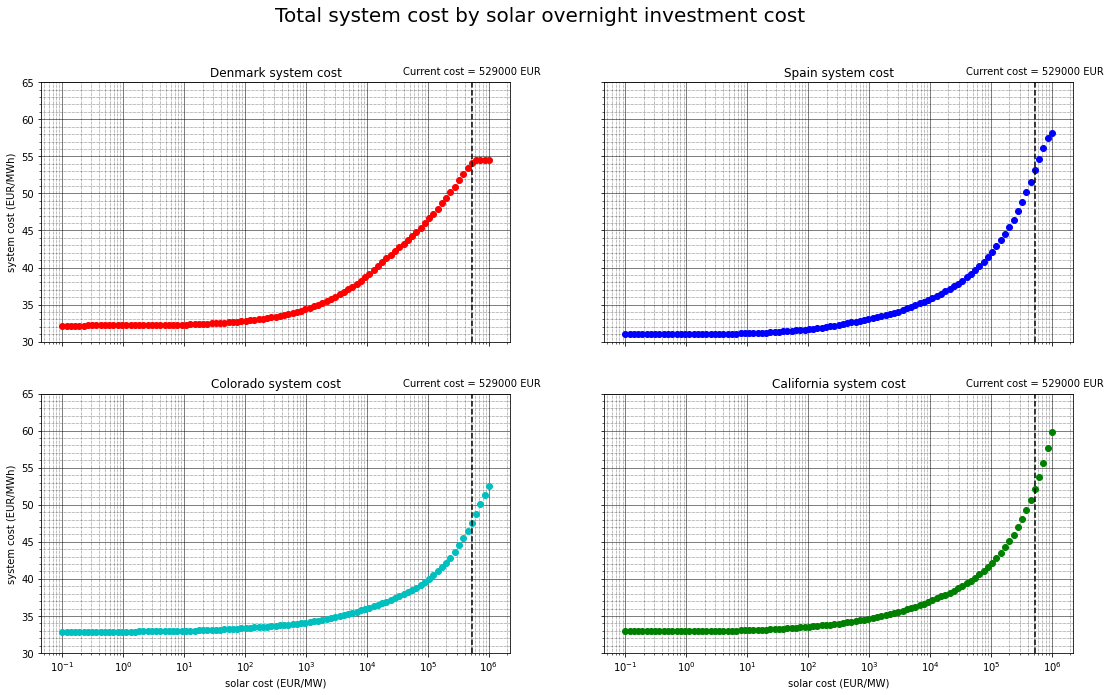

In [148]:

DNK_cst = [x[3] for x in DNK_solar_data]
ESP_cst = [x[3] for x in ESP_solar_data]
CAL_cst = [x[3] for x in CAL_solar_data]
CO_cst = [x[3] for x in CO_solar_data]




fig, axs = plt.subplots(2,2)
axs[0, 0].plot(s_cost, DNK_cst, 'ro')
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(s_cost, ESP_cst, 'bo')
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(s_cost, CO_cst, 'co')
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(s_cost, CAL_cst, 'go')
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_ylim(30, 65)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,66, "Current cost = 529000 EUR", horizontalalignment = "center")

plt.suptitle("Total system cost by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/TotalSystemCostbySolarCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 2.4 Curtailment Percentage <a name="sub2.4"></a>

Like solar penetration, we need to run the optimization for every solar cost. We plot on a log scale for the y axis

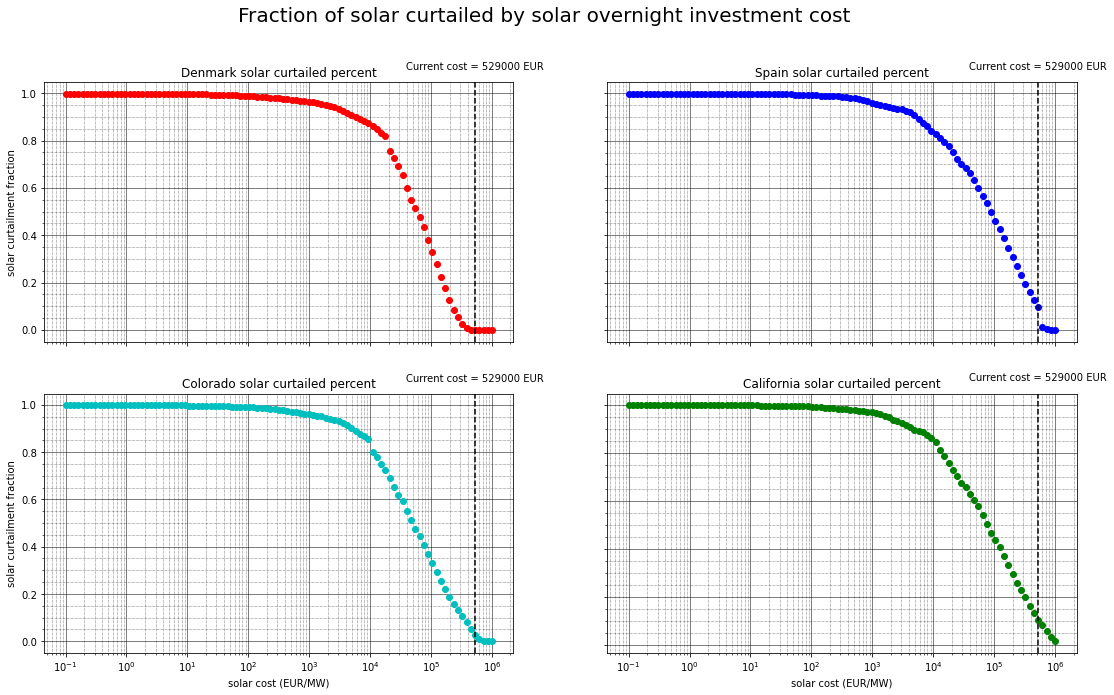

In [149]:
'''express curtailment as fraction of potential production. use log scale. extend x axis to todays cost. Plot solar and wind
also. renewables. plot wind solar gas with solar cost. Plot similar graphs with wind cost--different sensitivities?

plot system cost as well.'''

#This is our y axis. sc = solar curtailment
DNK_sc = list(map(abs, [x[4] for x in DNK_solar_data]))
ESP_sc = list(map(abs, [x[4] for x in ESP_solar_data]))
CAL_sc = list(map(abs, [x[4] for x in CAL_solar_data]))
CO_sc = list(map(abs, [x[4] for x in CO_solar_data]))




fig, axs = plt.subplots(2,2)
axs[0, 0].plot(s_cost, DNK_sc, 'ro')
axs[0, 0].set_title("Denmark solar curtailed percent")
axs[0, 1].plot(s_cost, ESP_sc, 'bo')
axs[0, 1].set_title("Spain solar curtailed percent")
axs[1, 0].plot(s_cost, CO_sc, 'co')
axs[1, 0].set_title("Colorado solar curtailed percent")
axs[1, 1].plot(s_cost, CAL_sc, 'go')
axs[1, 1].set_title("California solar curtailed percent")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='solar curtailment fraction')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,1.1, "Current cost = 529000 EUR", horizontalalignment = "center")

plt.suptitle("Fraction of solar curtailed by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/FracSolarCurtailbySolarCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 2.5 Mismatch at low solar cost

## 3. Variation by wind cost <a name="section-three"></a>

When varying by solar cost, we now know system behavior of the following: penetration of each resource, solar curtailment as a fraction of production, and total system cost. We want to do the same for wind.

### 3.1 Running the optimization <a name="sub3.1"></a>

In [124]:

def find_wind_data(n, wind_cost):
    
    annualized_wind_cost = 0.08442684282600257 * wind_cost
    n.generators.loc[['onshorewind'],['capital_cost']] = annualized_wind_cost
    #this substitutes the current wind cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    solar_penetration = n.generators_t.p['solar'].sum()/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()/sum(n.generators_t.p.sum())
    
    #The following determines system cost#
    systemcost = n.objective/n.loads_t.p.sum()
    
    #The following determines curtailment as a percent of generated capacity#
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    #first three in tuple are for penetration[0-2], then system cost[3], then curtailment[4]
    return (solar_penetration, wind_penetration, gas_penetration, systemcost, curtailment)




reset_stats(network)
reset_stats(nspain)
reset_stats(ncal)
reset_stats(nco)

#These four below return 100 points of cost vs solar penetration. 
DNK_wind_data = list(map(find_wind_data, repeat(network), np.logspace(-1, 7, 101)))
ESP_wind_data = list(map(find_wind_data, repeat(nspain), np.logspace(-1, 7, 101)))
CAL_wind_data = list(map(find_wind_data, repeat(ncal), np.logspace(-1, 7, 101)))
CO_wind_data = list(map(find_wind_data, repeat(nco), np.logspace(-1, 7, 101)))



print(DNK_wind_data[0:5])
print(ESP_wind_data[0:5])
print(CAL_wind_data[0:5])
print(CO_wind_data[0:5])

#print(end-start)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p570w7bz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x25ec0cc1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-03, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4502414e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  1.450241446e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-so_0m0a1.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb1b50760
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7434503e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  1.743450275e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c85w2ezm.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x9c8bb717
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0960910e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  2.096091006e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 2.10e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_1pfz54y.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x183e2857
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5201874e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  2.520187432e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ekg0vyey.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x5a7152c9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0298246e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  3.029824571e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ffv8s4tl.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x9ff463d3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6426946e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.08 seconds
Optimal objective  3.642694579e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-phyh2coc.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xbff50a67
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3794097e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  4.379409676e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6e91e3z9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd0af0e43
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2653916e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  5.265391599e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qhr87mwc.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf6236006
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3303563e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  6.330356299e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7fx2dbfz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa97ec54b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6107187e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  7.610718698e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 7.61e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t0q3gwmq.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x08d493bb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1501080e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.09 seconds
Optimal objective  9.150107995e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 9.15e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-077ap3yt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x7a644479
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1000742e+05   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.08 seconds
Optimal objective  1.100074181e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.26s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3ogv1wz_.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x325c1b8f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3225831e+05   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.08 seconds
Optimal objective  1.322583096e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tt4afwm6.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc63d789d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5900954e+05   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.08 seconds
Optimal objective  1.590095358e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rwgk_o5r.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0411bd19
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61312 rows and 26276 columns
Presolve time: 0.05s
Presolved: 8 rows, 8 columns, 17 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal    

INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tbnpyw7z.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xcb2da6dc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61312 rows and 26276 columns
Presolve time: 0.06s
Presolved: 8 rows, 8 columns, 17 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal    

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k66uy9vf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf47fc34d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61312 rows and 26276 columns
Presolve time: 0.05s
Presolved: 8 rows, 8 columns, 17 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal    

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-n7okjof1.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xeacc704a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61296 rows and 26265 columns
Presolve time: 0.05s
Presolved: 24 rows, 19 columns, 52 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.400e+01
 Factor NZ  : 2.400e+02
 Factor Ops : 2.920e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vw564e5r.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8dd2d9a8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61284 rows and 26257 columns
Presolve time: 0.05s
Presolved: 36 rows, 27 columns, 78 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.660e+02
 Factor NZ  : 4.810e+02
 Factor Ops : 7.603e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-anyg9g_5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xff0eb413
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61212 rows and 26213 columns
Presolve time: 0.05s
Presolved: 108 rows, 71 columns, 230 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.620e+02
 Factor NZ  : 4.960e+02
 Factor Ops : 2.428e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6rvzhy39.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x5e393806
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61180 rows and 26185 columns
Presolve time: 0.05s
Presolved: 140 rows, 99 columns, 306 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.100e+02
 Factor NZ  : 7.040e+02
 Factor Ops : 3.740e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rc4rb0iy.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe5a18cac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61134 rows and 26147 columns
Presolve time: 0.06s
Presolved: 186 rows, 137 columns, 413 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.790e+02
 Factor NZ  : 9.850e+02
 Factor Ops : 5.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0hfoaxzm.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6c040676
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61072 rows and 26104 columns
Presolve time: 0.06s
Presolved: 248 rows, 180 columns, 549 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.720e+02
 Factor NZ  : 1.298e+03
 Factor Ops : 7.142e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 8.34e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j81p7iv4.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x472a16f8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60954 rows and 26025 columns
Presolve time: 0.06s
Presolved: 366 rows, 259 columns, 805 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 5.490e+02
 Factor NZ  : 1.871e+03
 Factor Ops : 1.014e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-a9twdmcv.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6395309c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [7e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60818 rows and 25927 columns
Presolve time: 0.06s
Presolved: 502 rows, 357 columns, 1107 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.530e+02
 Factor NZ  : 2.587e+03
 Factor Ops : 1.412e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ccgv9h1o.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd82bf04b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60536 rows and 25724 columns
Presolve time: 0.06s
Presolved: 784 rows, 560 columns, 1733 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.176e+03
 Factor NZ  : 4.070e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.235e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objec

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_r6lk_ix.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x2de9662b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60274 rows and 25548 columns
Presolve time: 0.06s
Presolved: 1046 rows, 736 columns, 2302 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.569e+03
 Factor NZ  : 5.347e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.905e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h3jc3m5b.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x3af0fc67
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59940 rows and 25318 columns
Presolve time: 0.05s
Presolved: 1380 rows, 966 columns, 3033 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.070e+03
 Factor NZ  : 7.020e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.801e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 2.10e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cc09ihh0.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x09b57fba
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59618 rows and 25097 columns
Presolve time: 0.06s
Presolved: 1702 rows, 1187 columns, 3737 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.553e+03
 Factor NZ  : 8.627e+03 (roughly 1 MByte of memory)
 Factor Ops : 4.660e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obj

INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6oiqynmo.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4a20eea0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59240 rows and 24846 columns
Presolve time: 0.05s
Presolved: 2080 rows, 1438 columns, 4555 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.120e+03
 Factor NZ  : 1.045e+04 (roughly 2 MBytes of memory)
 Factor Ops : 5.603e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kk2omcsl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4bb3e751
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58800 rows and 24535 columns
Presolve time: 0.06s
Presolved: 2520 rows, 1749 columns, 5526 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.780e+03
 Factor NZ  : 1.271e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.845e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-481s0pqk.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0696eec9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58272 rows and 24185 columns
Presolve time: 0.05s
Presolved: 3048 rows, 2099 columns, 6668 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.572e+03
 Factor NZ  : 1.525e+04 (roughly 2 MBytes of memory)
 Factor Ops : 8.159e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ks5fpvqy.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x30fcb9e3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 57770 rows and 23840 columns
Presolve time: 0.06s
Presolved: 3550 rows, 2444 columns, 7766 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 5.325e+03
 Factor NZ  : 1.776e+04 (roughly 3 MBytes of memory)
 Factor Ops : 9.500e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_181z2bi.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x638c5ae6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 57196 rows and 23435 columns
Presolve time: 0.06s
Presolved: 4124 rows, 2849 columns, 9032 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 6.186e+03
 Factor NZ  : 2.071e+04 (roughly 3 MBytes of memory)
 Factor Ops : 1.111e+05 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-90knvvbc.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6df467a5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56256 rows and 22800 columns
Presolve time: 0.06s
Presolved: 5064 rows, 3484 columns, 11077 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.596e+03
 Factor NZ  : 2.532e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.354e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 7.61e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0zrcdzzn.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfe7a139e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 55318 rows and 22164 columns
Presolve time: 0.06s
Presolved: 6002 rows, 4120 columns, 13120 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 9.003e+03
 Factor NZ  : 2.994e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.599e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 9.15e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ei8ex_dr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4a1b3b1d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 54318 rows and 21471 columns
Presolve time: 0.06s
Presolved: 7002 rows, 4813 columns, 15313 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.050e+04
 Factor NZ  : 3.498e+04 (roughly 5 MBytes of memory)
 Factor Ops : 1.870e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1j1wc8eb.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x9e24f7d2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 53122 rows and 20649 columns
Presolve time: 0.07s
Presolved: 8198 rows, 5635 columns, 17929 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.230e+04
 Factor NZ  : 4.096e+04 (roughly 6 MBytes of memory)
 Factor Ops : 2.190e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.24s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ilvcvhn2.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x45aa45cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51886 rows and 19814 columns
Presolve time: 0.07s
Presolved: 9434 rows, 6470 columns, 20618 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.415e+04
 Factor NZ  : 4.702e+04 (roughly 7 MBytes of memory)
 Factor Ops : 2.509e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-63sxeopi.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb90a236a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 50562 rows and 18928 columns
Presolve time: 0.06s
Presolved: 10758 rows, 7356 columns, 23490 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.614e+04
 Factor NZ  : 5.345e+04 (roughly 8 MBytes of memory)
 Factor Ops : 2.845e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7mf__8s8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4fd29f29
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 49102 rows and 17930 columns
Presolve time: 0.06s
Presolved: 12218 rows, 8354 columns, 26678 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.833e+04
 Factor NZ  : 6.070e+04 (roughly 9 MBytes of memory)
 Factor Ops : 3.231e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3wufjewk.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc6e7ef4d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 47220 rows and 16673 columns
Presolve time: 0.06s
Presolved: 14100 rows, 9611 columns, 30758 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.115e+04
 Factor NZ  : 6.982e+04 (roughly 10 MBytes of memory)
 Factor Ops : 3.707e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-55vb2ttp.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xbbf1cd4d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 45770 rows and 15665 columns
Presolve time: 0.06s
Presolved: 15550 rows, 10619 columns, 33941 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.332e+04
 Factor NZ  : 7.716e+04 (roughly 11 MBytes of memory)
 Factor Ops : 4.103e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gzswta5a.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0366a22a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43936 rows and 14453 columns
Presolve time: 0.06s
Presolved: 17384 rows, 11831 columns, 37904 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.608e+04
 Factor NZ  : 8.594e+04 (roughly 13 MBytes of memory)
 Factor Ops : 4.556e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kb4ziqm1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xbe1f9542
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41996 rows and 13155 columns
Presolve time: 0.06s
Presolved: 19324 rows, 13129 columns, 42112 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.899e+04
 Factor NZ  : 9.535e+04 (roughly 14 MBytes of memory)
 Factor Ops : 5.048e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-814chuwf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0cda4484
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 39648 rows and 11595 columns
Presolve time: 0.07s
Presolved: 21672 rows, 14689 columns, 47194 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.251e+04
 Factor NZ  : 1.067e+05 (roughly 16 MBytes of memory)
 Factor Ops : 5.635e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k2sdk9t0.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6a877c03
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 38084 rows and 10467 columns
Presolve time: 0.06s
Presolved: 23236 rows, 15817 columns, 50668 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.485e+04
 Factor NZ  : 1.149e+05 (roughly 17 MBytes of memory)
 Factor Ops : 6.094e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m7rl2cvp.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x43626846
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.34e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zi_t3e5a.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x540d07d4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3jjv6ph5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xdc64d238
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xay8l8cb.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x04e90c3b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2iee2qwr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x9183135d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sd8rjb23.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8f364a59
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5o_mfo35.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf0acf4ee
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.96e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-agq2dysd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb466b1e9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u0hufst3.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4e4e2cc1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.20e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e3e26qi4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x863f5e8f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7pvftla6.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8448da2d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3ih_ph4r.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x3c5acecd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.60e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oernf2an.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf15e7668
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.74e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-r1ip1iat.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xbf1eb537
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.89e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7aj63if4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x00a71396
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3yy0wwfz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x28d0bf94
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.23e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-44rkft0w.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe7564708
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.41e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-iztx0gt0.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe184e2b3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.63e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gkt1y539.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf4d11b77
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.88e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5zqz_59q.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd7a882e7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.14e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yypz3thf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xefe938d9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.41e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dbaz2ikj.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x98439def
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.71e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6y8qaxsz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4fe4dbda
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.02e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sy01_30u.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x92bf8081
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.36e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-duvdn7vd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xaf4ead32
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.73e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h5bpu6d_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x2ec9ae66
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.12e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-20t330in.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0fdcd8a1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.54e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c1c_af7k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe996e90a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.00e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fvsbkqxj.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xdd3327ac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.49e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_necox91.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf7c37918
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.01e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-31p26zv2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x95cfbdba
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.58e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4nyrwatr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x05967eed
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.18e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ww2ml4lf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x992e389e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.81e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vsz68af7.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe8495ad5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cfj0jsv3.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe9679416
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5sw7akzs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x2284d681
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ffqdtb8l.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x28f1b404
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7o5mrwcd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x96da7ea0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y1fmgdqy.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa8c6216d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wwwxi7qx.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x32b0ff19
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.08s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

  96   1.56234244e+09  1.56234040e+09  2.91e-07 1.49e-11  4.80e-02     1s
  97   1.56234239e+09  1.56234239e+09  7.52e-06 5.82e-11  4.02e-06     1s
  98   1.56234239e+09  1.56234239e+09  8.40e-10 4.37e-11  5.47e-12     1s

Barrier solved model in 98 iterations and 1.30 seconds
Optimal objective 1.56234239e+09

Crossover log...

       3 DPushes remaining with DInf 0.0000000e+00                 1s
       0 DPushes remaining with DInf 0.0000000e+00                 1s

    1007 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 4.2018172e-10      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1013    1.5623424e+09   0.000000e+00   0.000000e+00      1s

Solved with barrier
Solved in 1013 iterations and 1.36 seconds
Optimal objective  1.562342388e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rh44pk5_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6d482053
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.66e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gbp162ex.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x7c390a6c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-iox2ls7j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x71ed3582
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jy2cv23f.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x6c525274
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.96e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wpn0ul5k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd67ad18d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vkuxorua.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc796d71e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wwar6l19.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe23ade65
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v9e_eao2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa2551b38
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h4r4m18u.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc8e95ee9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-is1c7yop.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfb48cd19
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fmsrs910.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xde32767f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bh5c4f9s.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x15fc0b0b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-994bk1l9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfc2f3ee6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.77s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-alq4cek6.lp
Reading time = 0.18 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xea47ef5a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.11s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8adwhjre.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xf7e2d3f1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-03, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-w2mso2z3.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xfff20f98
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2dk5qdy6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xb4d1f5f1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4ti26ot7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x0e265aed
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 2.55e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tpv9b3t1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4c05a5c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-a_c7jp0o.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa3cc56cd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 3.69e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-umtybe3q.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x46edc64b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uvvymo6j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x423851f9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 5.33e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k4akdcaz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2308fd08
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yg787rzs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x1e884385
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 7.71e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-07kivpgs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x49f276be
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 9.27e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-eamswgnp.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x39f2790a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t7lfk3jr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x18b33ed2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-grbq2e4g.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x828de2c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v4i_isgl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe8f739f3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dcv9mcfb.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x56fc20c3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pl515zll.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9b2e2bdd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-d_psnwmr.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x1f29220a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 3.36e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q8n37mvf.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe45c9088
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_7zn0xl3.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x20818388
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sa97xoy_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xd3601460
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 5.85e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xvyvnmb6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xab7c9b5d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 7.03e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_1un7g6d.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x817ab571
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 8.45e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2iqgz0o8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa273df65
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.04s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yb4ts_t2.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xff2734cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [7e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l84jfqgy.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6d85c4aa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ihbt5c_q.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x8adb7ddb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61315 rows and 26279 columns
Presolve time: 0.05s
Presolved: 5 rows, 5 columns, 10 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal    

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0heounmo.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x17efb1ce
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61308 rows and 26272 columns
Presolve time: 0.06s
Presolved: 12 rows, 12 columns, 27 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.800e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oisnwd0j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x337fbb2c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61282 rows and 26254 columns
Presolve time: 0.05s
Presolved: 38 rows, 30 columns, 84 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.650e+02
 Factor NZ  : 5.470e+02
 Factor Ops : 9.371e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.55e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1qv3pex3.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9514a86d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61200 rows and 26200 columns
Presolve time: 0.05s
Presolved: 120 rows, 84 columns, 261 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.800e+02
 Factor NZ  : 5.940e+02
 Factor Ops : 3.110e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ba7067vd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xd0ead989
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61128 rows and 26145 columns
Presolve time: 0.05s
Presolved: 192 rows, 139 columns, 424 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.880e+02
 Factor NZ  : 9.980e+02
 Factor Ops : 5.454e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 3.69e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f11squ60.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x7c96f947
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60932 rows and 26006 columns
Presolve time: 0.05s
Presolved: 388 rows, 278 columns, 857 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 5.820e+02
 Factor NZ  : 2.012e+03
 Factor Ops : 1.102e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bk2h40xh.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x60370532
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60642 rows and 25803 columns
Presolve time: 0.05s
Presolved: 678 rows, 481 columns, 1495 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.017e+03
 Factor NZ  : 3.491e+03
 Factor Ops : 1.905e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 5.33e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uqb9ojjz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc4be94a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60262 rows and 25536 columns
Presolve time: 0.05s
Presolved: 1058 rows, 748 columns, 2332 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.587e+03
 Factor NZ  : 5.437e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.966e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ks0kqjpk.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc80339dd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59328 rows and 24913 columns
Presolve time: 0.05s
Presolved: 1992 rows, 1371 columns, 4356 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.988e+03
 Factor NZ  : 9.954e+03 (roughly 1 MByte of memory)
 Factor Ops : 5.319e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obj

INFO:pypsa.linopf:Optimization successful. Objective value: 7.71e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-skqyzq0u.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x1231794d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58236 rows and 24164 columns
Presolve time: 0.06s
Presolved: 3084 rows, 2120 columns, 6743 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.626e+03
 Factor NZ  : 1.540e+04 (roughly 2 MBytes of memory)
 Factor Ops : 8.226e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 9.27e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7z3vea5u.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x41c58c0f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 57074 rows and 23359 columns
Presolve time: 0.05s
Presolved: 4246 rows, 2925 columns, 9291 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 6.369e+03
 Factor NZ  : 2.126e+04 (roughly 3 MBytes of memory)
 Factor Ops : 1.138e+05 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2n3zbbx5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2a53e263
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 54862 rows and 21967 columns
Presolve time: 0.06s
Presolved: 6458 rows, 4317 columns, 14001 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 9.687e+03
 Factor NZ  : 3.129e+04 (roughly 5 MBytes of memory)
 Factor Ops : 1.632e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4mp3mxgf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc39971c4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 52894 rows and 20628 columns
Presolve time: 0.06s
Presolved: 8426 rows, 5656 columns, 18292 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.264e+04
 Factor NZ  : 4.102e+04 (roughly 6 MBytes of memory)
 Factor Ops : 2.148e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-grb1cq95.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4558051f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 50446 rows and 19032 columns
Presolve time: 0.06s
Presolved: 10874 rows, 7252 columns, 23560 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.631e+04
 Factor NZ  : 5.256e+04 (roughly 8 MBytes of memory)
 Factor Ops : 2.737e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-d7f2y7k5.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x71b6ab86
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 47598 rows and 17109 columns
Presolve time: 0.06s
Presolved: 13722 rows, 9175 columns, 29755 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.058e+04
 Factor NZ  : 6.652e+04 (roughly 10 MBytes of memory)
 Factor Ops : 3.472e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-756qzxdm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xcfc1e5b9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 44630 rows and 15088 columns
Presolve time: 0.06s
Presolved: 16690 rows, 11196 columns, 36228 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.504e+04
 Factor NZ  : 8.120e+04 (roughly 12 MBytes of memory)
 Factor Ops : 4.251e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6_jk_71k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x915e3c86
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41532 rows and 12977 columns
Presolve time: 0.07s
Presolved: 19788 rows, 13307 columns, 42986 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.968e+04
 Factor NZ  : 9.654e+04 (roughly 14 MBytes of memory)
 Factor Ops : 5.065e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 3.36e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3lajju7r.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x404ae469
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 38804 rows and 11121 columns
Presolve time: 0.07s
Presolved: 22516 rows, 15163 columns, 48934 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.377e+04
 Factor NZ  : 1.100e+05 (roughly 16 MBytes of memory)
 Factor Ops : 5.780e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s9hmpwm7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa2015f87
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 36950 rows and 9858 columns
Presolve time: 0.08s
Presolved: 24370 rows, 16426 columns, 52978 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.656e+04
 Factor NZ  : 1.192e+05 (roughly 17 MBytes of memory)
 Factor Ops : 6.267e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rzm_k9pu.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x515e955c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35670 rows and 9020 columns
Presolve time: 0.07s
Presolved: 25650 rows, 17264 columns, 55736 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.848e+04
 Factor NZ  : 1.253e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.578e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.85e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e60nl6z2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x028d98ab
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34740 rows and 8444 columns
Presolve time: 0.07s
Presolved: 26580 rows, 17840 columns, 57707 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.987e+04
 Factor NZ  : 1.294e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.778e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.03e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-d2ss744a.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xb638c4e3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.10s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.45e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bng8545v.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5c76c17f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uisx564p.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x319ac4cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b1o8apmf.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xfb07f95d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yc4xaect.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2d438b00
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bscb3o6j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x831ab16d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-utm5jhh6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2585001f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.55e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-09gw43cx.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe75ccf32
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5nyhruo8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6144c9ad
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.69e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jro8_ko2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6a5037df
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jykfjkk_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3d44c74d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.33e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-96swz95g.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9833f3e9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.41e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-38v9n9p8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc71c3e2a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.71e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nrozo0gy.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xdbfccdc4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.27e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nlq1j4nf.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xda083092
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cq09kt4d.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xec542e61
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-58y_6r4t.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xf58caf0d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.48e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_7w33dhu.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x7055b87d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.64e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j4_n0dg_.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x804c2589
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l1hi7aic.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5b356c51
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.93e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h9wcw1j_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x1c484386
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y4dufj2e.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x189577e6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.27e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s7fjpkit.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x86556e0d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b7ayiu9u.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6dafbb8e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-39crk69p.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x80d61b88
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.94e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j85ft57i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x82137103
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b6_y40u7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc5c4de13
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-itl3pkic.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3bb611ef
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1kgz4ahi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2b40c06c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ppv6n5l2.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9d768049
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fn8o2cwx.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4c1a37af
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-36201yva.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6ef8a98c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.69e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7qysz6_z.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3e513b04
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t6cki70w.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xafba4514
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.93e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0yg2ybd1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc36d743e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.64e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-mybkhxoo.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xf48fe444
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.42e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nqih0h93.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4b014bbf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.26e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t1gfx5bj.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x77913a58
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.02e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f817glas.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2e2e3269
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-512f2any.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe6c4911c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3dg9gago.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3546ef6d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gzxegsrg.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xef98b00f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k1mr_k2v.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x70f1b69c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-das_swzg.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xad1a1fe6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v4zfvwcl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5c1da4ce
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7nfg18cr.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xd76881fc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-28_vk6of.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc792b082
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-htzums8b.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x64a8394c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2altb2ys.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x752007a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_uhaien2.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x0d91ddc3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wbmk2_20.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5b323903
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-97yb3bwb.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc044642e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2fjggsw5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x50c69630
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7a7mgkt8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x26376f15
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v3ipa2ih.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x9f66fb39
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-03, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.04s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s_izl67j.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb9bbe1ef
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.04s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-02en52r9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa60f8f75
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.04s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 9.14e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2okjnevf.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8b410c4f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.04s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7_taohf4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcc241b0e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4w5vlko1.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x145661b0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tmod2wt4.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5f15c9ef
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uu0kv5dv.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xd82bb14c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uiuverlv.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x49a3372a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tv2v5mb1.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xea2fe9cb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ow4p_g1j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa9eccfc3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-aghhk59r.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x55ccb3f9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fgv9bjpw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x18744954
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5pkvu3ft.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x691846a7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 6.93e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pyncgr_6.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5ca5b471
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 8.34e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3bfgoxxz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6472d4ee
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i0te23eq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8b24d536
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.04s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_671qvdl.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8e1bf11a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-amnndvcm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc969dc68
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gkfgfuof.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe49e9b56
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61303 rows and 26273 columns
Presolve time: 0.05s
Presolved: 17 rows, 11 columns, 34 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.500e+01
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i48x91ti.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xd34ecc2e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61300 rows and 26269 columns
Presolve time: 0.05s
Presolved: 20 rows, 15 columns, 42 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.900e+01
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gey49qik.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x12531f92
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61298 rows and 26267 columns
Presolve time: 0.05s
Presolved: 22 rows, 17 columns, 47 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.300e+01
 Factor NZ  : 2.530e+02
 Factor Ops : 3.795e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9aqgmsk_.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x037ec0bc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61294 rows and 26263 columns
Presolve time: 0.05s
Presolved: 26 rows, 21 columns, 57 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.400e+01
 Factor NZ  : 2.790e+02
 Factor Ops : 3.609e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-eccgu73x.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xd8c25efe
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61270 rows and 26248 columns
Presolve time: 0.05s
Presolved: 50 rows, 36 columns, 108 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.130e+02
 Factor NZ  : 9.100e+02
 Factor Ops : 1.959e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h8bhcrdh.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x7f9e2f46
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [7e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61226 rows and 26222 columns
Presolve time: 0.05s
Presolved: 94 rows, 62 columns, 200 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.410e+02
 Factor NZ  : 4.310e+02
 Factor Ops : 2.101e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 5.26e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dm7yesuk.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x929253ae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61180 rows and 26190 columns
Presolve time: 0.05s
Presolved: 140 rows, 94 columns, 301 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.100e+02
 Factor NZ  : 6.640e+02
 Factor Ops : 3.360e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-30ysb1wg.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x06126d57
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61124 rows and 26144 columns
Presolve time: 0.05s
Presolved: 196 rows, 140 columns, 431 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.940e+02
 Factor NZ  : 1.004e+03
 Factor Ops : 5.428e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p6ycsktf.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc2b910d3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60966 rows and 26029 columns
Presolve time: 0.05s
Presolved: 354 rows, 255 columns, 783 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 5.310e+02
 Factor NZ  : 1.845e+03
 Factor Ops : 1.014e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 9.14e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8bhpfkrd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xf4ede118
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60752 rows and 25882 columns
Presolve time: 0.05s
Presolved: 568 rows, 402 columns, 1251 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 8.520e+02
 Factor NZ  : 2.914e+03
 Factor Ops : 1.585e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qghuv3lb.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x23f23ae6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60482 rows and 25688 columns
Presolve time: 0.05s
Presolved: 838 rows, 596 columns, 1850 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.257e+03
 Factor NZ  : 4.331e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.371e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objec

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bb1gkhfh.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xbdef4a68
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60096 rows and 25411 columns
Presolve time: 0.05s
Presolved: 1224 rows, 873 columns, 2706 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.836e+03
 Factor NZ  : 6.354e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.492e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y4_4fu4x.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5556903f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59496 rows and 25000 columns
Presolve time: 0.05s
Presolved: 1824 rows, 1284 columns, 4017 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.736e+03
 Factor NZ  : 9.342e+03 (roughly 1 MByte of memory)
 Factor Ops : 5.086e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obj

INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nfu5h_eh.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x25d00927
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58924 rows and 24600 columns
Presolve time: 0.05s
Presolved: 2396 rows, 1684 columns, 5275 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.594e+03
 Factor NZ  : 1.226e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.667e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hipxcsqa.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0449c82e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58176 rows and 24068 columns
Presolve time: 0.05s
Presolved: 3144 rows, 2216 columns, 6929 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.716e+03
 Factor NZ  : 1.614e+04 (roughly 2 MBytes of memory)
 Factor Ops : 8.803e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t0_l252w.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x852093c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 57204 rows and 23390 columns
Presolve time: 0.05s
Presolved: 4116 rows, 2894 columns, 9065 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 6.174e+03
 Factor NZ  : 2.108e+04 (roughly 3 MBytes of memory)
 Factor Ops : 1.148e+05 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6wvkeqst.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x124040dd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56048 rows and 22554 columns
Presolve time: 0.05s
Presolved: 5272 rows, 3730 columns, 11635 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.908e+03
 Factor NZ  : 2.719e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.488e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 3.99e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0zt8ww_q.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x36f1a3f1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 54012 rows and 21160 columns
Presolve time: 0.05s
Presolved: 7308 rows, 5124 columns, 16083 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.096e+04
 Factor NZ  : 3.732e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.029e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 4.80e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yeunkwae.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x927bde2b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51886 rows and 19672 columns
Presolve time: 0.05s
Presolved: 9434 rows, 6612 columns, 20760 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.415e+04
 Factor NZ  : 4.816e+04 (roughly 7 MBytes of memory)
 Factor Ops : 2.617e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 5.77e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m7r3jhog.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6c6e2ce6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 49634 rows and 18143 columns
Presolve time: 0.05s
Presolved: 11686 rows, 8141 columns, 25667 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.753e+04
 Factor NZ  : 5.927e+04 (roughly 8 MBytes of memory)
 Factor Ops : 3.205e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 6.93e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oqwm2q1k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcec49d27
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 46886 rows and 16273 columns
Presolve time: 0.06s
Presolved: 14434 rows, 10011 columns, 31659 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.165e+04
 Factor NZ  : 7.285e+04 (roughly 10 MBytes of memory)
 Factor Ops : 3.926e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 8.34e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bb81lbky.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x84f2887f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 44054 rows and 14410 columns
Presolve time: 0.06s
Presolved: 17266 rows, 11874 columns, 37770 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.590e+04
 Factor NZ  : 8.634e+04 (roughly 12 MBytes of memory)
 Factor Ops : 4.619e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j_32tyct.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x049a27f3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41234 rows and 12586 columns
Presolve time: 0.06s
Presolved: 20086 rows, 13698 columns, 43824 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.013e+04
 Factor NZ  : 9.952e+04 (roughly 14 MBytes of memory)
 Factor Ops : 5.286e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-got92q61.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6b9f7d9f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 38900 rows and 11119 columns
Presolve time: 0.06s
Presolved: 22420 rows, 15165 columns, 48792 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.363e+04
 Factor NZ  : 1.101e+05 (roughly 16 MBytes of memory)
 Factor Ops : 5.806e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6j0ally2.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5076c7a2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 36736 rows and 9836 columns
Presolve time: 0.06s
Presolved: 24584 rows, 16448 columns, 53321 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.688e+04
 Factor NZ  : 1.193e+05 (roughly 18 MBytes of memory)
 Factor Ops : 6.229e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wq98osux.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x624e6548
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35674 rows and 9167 columns
Presolve time: 0.06s
Presolved: 25646 rows, 17117 columns, 55583 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.847e+04
 Factor NZ  : 1.241e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.467e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p9w85g_b.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x79b92589
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35310 rows and 8915 columns
Presolve time: 0.06s
Presolved: 26010 rows, 17369 columns, 56381 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.902e+04
 Factor NZ  : 1.259e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.52e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pp_hd3bt.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc6789efe
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g9qvy8l4.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb71ada57
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dbue1mdx.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x3b856b24
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.38e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1ieywo_p.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xf5a571ff
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.26e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ussnit2i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5592e754
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-utaohjkt.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x60458817
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.60e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cki0rk2a.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x365feb77
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.14e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-80sw956u.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01f95f07
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2cb2gl11.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x255fa8c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-erl7im2_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x7e0a960e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j2yhw7y7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0c28fc2c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.62e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-mywkbybu.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x78e97859
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0l1bmyhz.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x91cc78b5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lfgjwoff.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x18bc1d54
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.91e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p8fwcu9_.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x30c51793
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9hdsuk_c.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0a31e931
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c8vgl_i7.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xdacb7af5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fyyl8dz1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe6a383c6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.43e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.38s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sdgrih6i.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x9ef2437a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.08s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.60e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1589qyh_.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb96eb265
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.79e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z3totbi7.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb433ad77
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.02e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7ftlcia8.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcf4aa990
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-86gg6jw4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x02a257e3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.59e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-58jkvvhm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x35e22f02
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.90e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g_bszk4a.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0f29382a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.23e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-acgc_640.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x1002983f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g50ehol2.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa041c528
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8jxq69dk.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x188d8db8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.34e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hdilwd_q.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcbb76994
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l1bass_3.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01efc3b9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lc9qah8t.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8445092e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5ke30ikb.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xbbe2a4f3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.08s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.50e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ztl3tntt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x4c763c74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.17e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b5g435_6.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x690fd1ba
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.89e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1oigewut.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe7964a96
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-241gark2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x602d932b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pqb2b_j0.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe4873ba9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.08s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oh06m4fr.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc1cc1841
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i8ht7vf8.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x2728e812
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.35e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_147we9x.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0dfefa92
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-iyvz5wma.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8187a87a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.55e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dq4s9wbt.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x68fec345
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t2u64yg1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x7e9586a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6tevg5ah.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xdf96e901
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p_wyoci4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe1e1d630
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cxvpuh_i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc3310572
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u3i0148e.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x142b7bae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kp2a8hya.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x11f7c1de
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vc32fzb5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa5f7e30e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vy32qjux.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcb1e8341
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-byhj0vgs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x9fc5d104
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lpox3chk.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x66a7aea5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ytjsbj3e.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x14405755
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-o9escozi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8f4d428c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_ffh24r1.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x2a855df0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b1q2f1f1.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf4f99ee9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-03, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-20xahkp4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x8e71082c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g9wu299y.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb0d51307
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 5.17e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-o_1z303d.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf6903b4d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 6.22e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xso9ypdi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5a96486a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7zqy774a.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x897b3a34
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 8.99e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-57p2s6xt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe14306d2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7va86w11.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x97d18ca2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0hc1jcjq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x4877a4c6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_nz8ed7k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x94697aed
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 1.88e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-izz___w1.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7e9bb8ab
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bampc3ta.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x551c7f4f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.06s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 2.71e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i1gj8hbj.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe65f27c8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 3.26e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ym5mobq4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x28ced437
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-a7qt3v8f.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x348c28c8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61218 rows and 26228 columns
Presolve time: 0.05s
Presolved: 102 rows, 56 columns, 206 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.520e+02
 Factor NZ  : 3.840e+02
 Factor Ops : 1.560e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jnc_ghy3.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc44e46d4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61218 rows and 26228 columns
Presolve time: 0.05s
Presolved: 102 rows, 56 columns, 206 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.520e+02
 Factor NZ  : 3.840e+02
 Factor Ops : 1.560e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k270xqbn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x555ff655
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61218 rows and 26228 columns
Presolve time: 0.05s
Presolved: 102 rows, 56 columns, 206 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.520e+02
 Factor NZ  : 3.840e+02
 Factor Ops : 1.560e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 6.82e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8undsz44.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x74d279a7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61204 rows and 26214 columns
Presolve time: 0.06s
Presolved: 116 rows, 70 columns, 241 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.010e+02
 Factor NZ  : 5.800e+02
 Factor Ops : 4.332e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 8.20e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kzo_6x09.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x975bca1e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61180 rows and 26190 columns
Presolve time: 0.05s
Presolved: 140 rows, 94 columns, 301 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.100e+02
 Factor NZ  : 6.640e+02
 Factor Ops : 3.360e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 9.86e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6ngk4aqw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xac028a51
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61162 rows and 26172 columns
Presolve time: 0.05s
Presolved: 158 rows, 112 columns, 346 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.370e+02
 Factor NZ  : 7.990e+02
 Factor Ops : 4.269e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5ute6vsn.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe5916482
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61150 rows and 26160 columns
Presolve time: 0.06s
Presolved: 170 rows, 124 columns, 376 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.550e+02
 Factor NZ  : 8.890e+02
 Factor Ops : 4.875e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g6qe_nru.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb8b00fe3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61130 rows and 26140 columns
Presolve time: 0.05s
Presolved: 190 rows, 144 columns, 426 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.850e+02
 Factor NZ  : 1.039e+03
 Factor Ops : 5.885e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lxdbq0zs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x8fc487f6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61116 rows and 26128 columns
Presolve time: 0.05s
Presolved: 204 rows, 156 columns, 459 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.060e+02
 Factor NZ  : 1.128e+03
 Factor Ops : 6.440e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x50674pe.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xcd9e49cb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61050 rows and 26084 columns
Presolve time: 0.05s
Presolved: 270 rows, 200 columns, 602 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.050e+02
 Factor NZ  : 1.447e+03
 Factor Ops : 8.101e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 2.48e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3is0zzek.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x483e7b09
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [7e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60994 rows and 26039 columns
Presolve time: 0.05s
Presolved: 326 rows, 245 columns, 731 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.890e+02
 Factor NZ  : 1.779e+03
 Factor Ops : 1.009e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b7fgtq_y.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd9879d12
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60814 rows and 25919 columns
Presolve time: 0.05s
Presolved: 506 rows, 365 columns, 1121 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.590e+02
 Factor NZ  : 2.649e+03
 Factor Ops : 1.462e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l0l5b_pe.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x82535aca
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60658 rows and 25799 columns
Presolve time: 0.06s
Presolved: 662 rows, 485 columns, 1475 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 9.930e+02
 Factor NZ  : 3.531e+03
 Factor Ops : 1.976e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.30e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s34salio.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd93594db
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60464 rows and 25651 columns
Presolve time: 0.05s
Presolved: 856 rows, 633 columns, 1914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.284e+03
 Factor NZ  : 4.618e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.607e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objec

INFO:pypsa.linopf:Optimization successful. Objective value: 5.17e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wasisask.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xcb3166a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60266 rows and 25502 columns
Presolve time: 0.05s
Presolved: 1054 rows, 782 columns, 2360 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.581e+03
 Factor NZ  : 5.711e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.234e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 6.22e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-abq940xq.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9891b806
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60014 rows and 25322 columns
Presolve time: 0.06s
Presolved: 1306 rows, 962 columns, 2918 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.959e+03
 Factor NZ  : 7.025e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.960e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obje

INFO:pypsa.linopf:Optimization successful. Objective value: 7.48e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5n8d8h3i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3b504476
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59648 rows and 25055 columns
Presolve time: 0.06s
Presolved: 1672 rows, 1229 columns, 3734 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.508e+03
 Factor NZ  : 8.978e+03 (roughly 1 MByte of memory)
 Factor Ops : 5.055e+04 (less than 1 second per iteration)
 Threads    : 1

                  Obj

INFO:pypsa.linopf:Optimization successful. Objective value: 8.99e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dk8_gnya.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x211be86a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 59248 rows and 24771 columns
Presolve time: 0.05s
Presolved: 2072 rows, 1513 columns, 4618 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.108e+03
 Factor NZ  : 1.105e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.194e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-clcluztn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xaa06ce9a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58762 rows and 24393 columns
Presolve time: 0.05s
Presolved: 2558 rows, 1891 columns, 5725 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.837e+03
 Factor NZ  : 1.383e+04 (roughly 2 MBytes of memory)
 Factor Ops : 7.827e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jvs93rsa.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb7e41c6d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58042 rows and 23879 columns
Presolve time: 0.05s
Presolved: 3278 rows, 2405 columns, 7319 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 4.917e+03
 Factor NZ  : 1.758e+04 (roughly 2 MBytes of memory)
 Factor Ops : 9.898e+04 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-atdfy9sq.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5208392a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 57124 rows and 23214 columns
Presolve time: 0.06s
Presolved: 4196 rows, 3070 columns, 9361 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 6.294e+03
 Factor NZ  : 2.244e+04 (roughly 3 MBytes of memory)
 Factor Ops : 1.261e+05 (less than 1 second per iteration)
 Threads    : 1

                  Ob

INFO:pypsa.linopf:Optimization successful. Objective value: 1.88e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f35u8qq8.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x663af8cb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 56144 rows and 22524 columns
Presolve time: 0.07s
Presolved: 5176 rows, 3760 columns, 11521 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.764e+03
 Factor NZ  : 2.747e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.536e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 2.26e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-azgobaa7.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5de67e79
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 55020 rows and 21732 columns
Presolve time: 0.07s
Presolved: 6300 rows, 4552 columns, 13999 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 9.450e+03
 Factor NZ  : 3.325e+04 (roughly 5 MBytes of memory)
 Factor Ops : 1.851e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 2.71e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wru59ss6.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5a44ce3f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 53550 rows and 20724 columns
Presolve time: 0.07s
Presolved: 7770 rows, 5560 columns, 17212 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.166e+04
 Factor NZ  : 4.058e+04 (roughly 6 MBytes of memory)
 Factor Ops : 2.242e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 3.26e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7nx9tfty.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x6bf90bc2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 52150 rows and 19749 columns
Presolve time: 0.06s
Presolved: 9170 rows, 6535 columns, 20287 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.376e+04
 Factor NZ  : 4.768e+04 (roughly 7 MBytes of memory)
 Factor Ops : 2.626e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9333yut9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x08560d12
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 50556 rows and 18672 columns
Presolve time: 0.06s
Presolved: 10764 rows, 7612 columns, 23755 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.615e+04
 Factor NZ  : 5.550e+04 (roughly 8 MBytes of memory)
 Factor Ops : 3.038e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 4.72e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e1w2e55i.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb6ddfc93
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 48904 rows and 17532 columns
Presolve time: 0.07s
Presolved: 12416 rows, 8752 columns, 27373 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.862e+04
 Factor NZ  : 6.379e+04 (roughly 9 MBytes of memory)
 Factor Ops : 3.483e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u8omfblu.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x6ffb899d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 46948 rows and 16240 columns
Presolve time: 0.07s
Presolved: 14372 rows, 10044 columns, 31599 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.156e+04
 Factor NZ  : 7.315e+04 (roughly 10 MBytes of memory)
 Factor Ops : 3.966e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 6.82e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-eqn0l5sw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf88135d4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 45262 rows and 15112 columns
Presolve time: 0.06s
Presolved: 16058 rows, 11172 columns, 35256 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.409e+04
 Factor NZ  : 8.133e+04 (roughly 12 MBytes of memory)
 Factor Ops : 4.394e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 8.20e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tt0x2__1.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd11fb880
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43210 rows and 13832 columns
Presolve time: 0.06s
Presolved: 18110 rows, 12452 columns, 39614 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.716e+04
 Factor NZ  : 9.054e+04 (roughly 13 MBytes of memory)
 Factor Ops : 4.843e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 9.86e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x645ux68.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x8adf7b30
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41898 rows and 12934 columns
Presolve time: 0.07s
Presolved: 19422 rows, 13350 columns, 42480 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.913e+04
 Factor NZ  : 9.707e+04 (roughly 14 MBytes of memory)
 Factor Ops : 5.191e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wqdzb_tt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2eaf1639
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 40092 rows and 11810 columns
Presolve time: 0.06s
Presolved: 21228 rows, 14474 columns, 46313 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.184e+04
 Factor NZ  : 1.052e+05 (roughly 15 MBytes of memory)
 Factor Ops : 5.585e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q5mnajab.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe79904a0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 38394 rows and 10766 columns
Presolve time: 0.07s
Presolved: 22926 rows, 15518 columns, 49904 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.439e+04
 Factor NZ  : 1.127e+05 (roughly 16 MBytes of memory)
 Factor Ops : 5.945e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uel5qeeh.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x843d1700
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 36204 rows and 9453 columns
Presolve time: 0.07s
Presolved: 25116 rows, 16831 columns, 54502 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.767e+04
 Factor NZ  : 1.221e+05 (roughly 18 MBytes of memory)
 Factor Ops : 6.385e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3dpctqq2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3aba25eb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.48e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-es41k3ix.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x70e9190a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hhqfi1j0.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc2d0ceb8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.47e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-w98zeq7o.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x756ee3e4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.11s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9qey3mq2.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xac47ad7e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-417wm8bg.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc4dca87e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.92e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fwpfp7su.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xeb911c8e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.05e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1jpm_ugf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc4424fc0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-a2ejgvq_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xad4b04bb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.36e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xsa6gt45.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x0b3f2ee8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.53e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-opfwxf3k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb2196cb1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.73e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j9dak4hl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x89f2c299
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.95e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c8y6qgz7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9dd96007
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.22e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h07l6_46.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2df6a098
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.49e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2kkq9a0c.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xce4d12a1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.78e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cn0he2rw.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x32ba1eca
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.08e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.26s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cfsjecsy.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x0c5b294b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.44e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rsaknwx8.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x35a31758
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.83e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zsw0wz7t.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf02ca299
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.24e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-izttwn4p.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x44561645
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.69e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hv8kfmsj.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x1b1ba5db
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.15e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hhdvx_rz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xfcb06a80
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.65e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hi7o6xay.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xab614798
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.21e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kg0nvh17.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xcf085dd2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.82e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-myvxr6nq.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x10da56bd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jz73z8ol.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2898f2c4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oayhtoia.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb201a297
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-09qkduma.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7a118f74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pjw_163o.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9148d80c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1anp4gor.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x4eae784d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7o83q5qt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe1c7eb98
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tp6ssw_u.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x06dd9262
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ddcroef_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x66529259
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4kq9rdj6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x52981967
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xdyxrciq.lp
Reading time = 0.17 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x4ed33621
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2kregiek.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5c0391e0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cx7mvl_w.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xffc1ee7e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cv_mxzoi.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb297700d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-je7kdngr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc2257f15
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y50oyw1k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x0ce676ee
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pkctb4lm.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7802df98
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g_r74nj6.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf107f59b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gbjaaxv8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3e7a0978
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-aug7aknf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7b8ad252
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ttvo64hy.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xab13c7f4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wrdo77qa.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7c6ef212
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fml826wy.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x27dc490e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ayh295wg.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xef98286d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q3trc0_1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd550a01b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l105kgdv.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x0afed32d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_i7ao5gs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x20f7449c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qb7rhf6b.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2946e15d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tjkhiuqa.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf187e789
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e+09


[(0.0, 1.0, 0.0, load    0.000442
dtype: float64, -0.9925497547230835), (0.0, 1.0, 0.0, load    0.000531
dtype: float64, -0.9925497547230835), (0.0, 1.0, 0.0, load    0.000639
dtype: float64, -0.9925497547230835), (0.0, 1.0, 0.0, load    0.000768
dtype: float64, -0.9925497547230835), (0.0, 1.0, 0.0, load    0.000923
dtype: float64, -0.9925497547230835)]
[(0.0, 1.0, 0.0, load    0.000059
dtype: float64, -0.9277081975818368), (0.0, 1.0, 0.0, load    0.000071
dtype: float64, -0.9277081975818368), (0.0, 1.0, 0.0, load    0.000085
dtype: float64, -0.9277081975818368), (0.0, 1.0, 0.0, load    0.000103
dtype: float64, -0.9277081975818368), (0.0, 1.0, 0.0, load    0.000123
dtype: float64, -0.9277081975818368)]
[(0.0, 1.0, 0.0, load    0.000206
dtype: float64, -0.9742381932078694), (0.0, 1.0, 0.0, load    0.000248
dtype: float64, -0.9742381932078694), (0.0, 1.0, 0.0, load    0.000298
dtype: float64, -0.9742381932078694), (0.0, 1.0, 0.0, load    0.000358
dtype: float64, -0.9742381932078694), (0.

### 3.2 Graph of penetration <a name="sub3.2"></a>
The code below creates a plot of penetration by wind cost

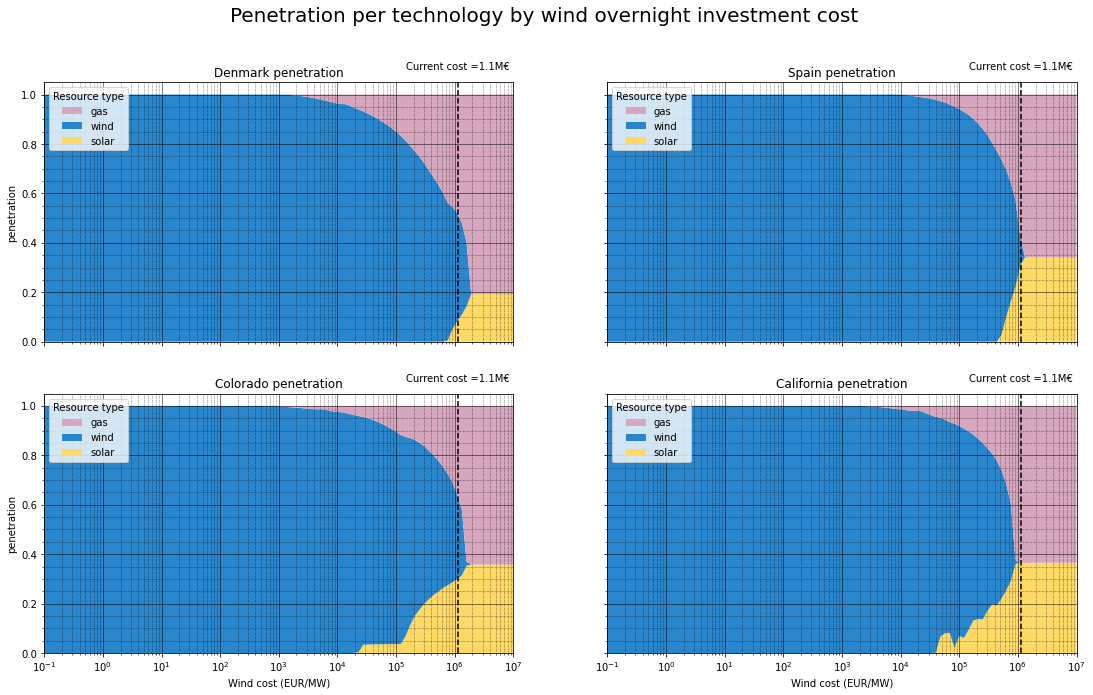

In [155]:
#This is our x axis, solar_cost (s_cost)
w_cost = np.logspace(-1, 7, 101)

#This is our y axis. sp = solar penetration, wp = wind penetration, gp = gas penetration
DNK_sp = [x[0] for x in DNK_wind_data]
ESP_sp = [x[0] for x in ESP_wind_data]
CAL_sp = [x[0] for x in CAL_wind_data]
CO_sp = [x[0] for x in CO_wind_data]

DNK_wp = [x[1] for x in DNK_wind_data]
ESP_wp = [x[1] for x in ESP_wind_data]
CAL_wp = [x[1] for x in CAL_wind_data]
CO_wp = [x[1] for x in CO_wind_data]

DNK_gp = [x[2] for x in DNK_wind_data]
ESP_gp = [x[2] for x in ESP_wind_data]
CAL_gp = [x[2] for x in CAL_wind_data]
CO_gp = [x[2] for x in CO_wind_data]




fig, axs = plt.subplots(2,2)
axs[0, 0].stackplot(w_cost, DNK_sp, DNK_wp, DNK_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 0].set_title("Denmark penetration")
axs[0, 1].stackplot(w_cost, ESP_sp, ESP_wp, ESP_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 1].set_title("Spain penetration")
axs[1, 0].stackplot(w_cost, CO_sp, CO_wp, CO_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 0].set_title("Colorado penetration")
axs[1, 1].stackplot(w_cost, CAL_sp, CAL_wp, CAL_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 1].set_title("California penetration")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_xlim(10**-1, 10**7)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Resource type', loc='upper left')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='Wind cost (EUR/MW)', ylabel='penetration')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,1.1, "Current cost =1.1M€", horizontalalignment = "center")

plt.suptitle("Penetration per technology by wind overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/PenetrationbyWindCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 3.3 Graph of System Cost <a name="sub3.3"></a>
The following code will create plots for system cost varying by wind cost

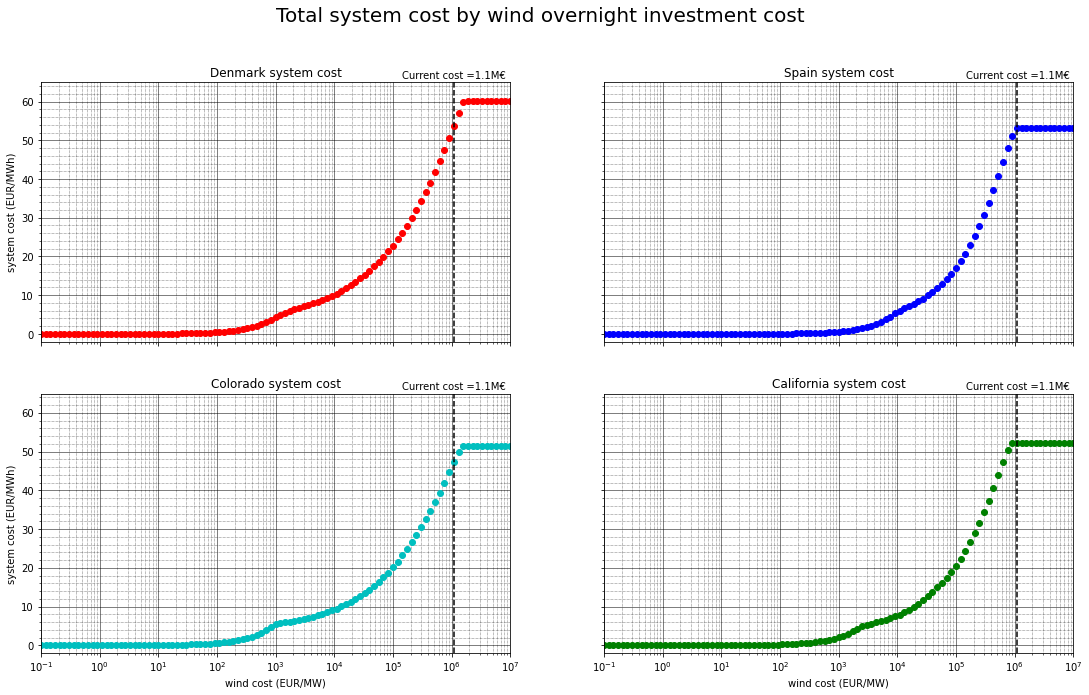

In [156]:
DNK_wcst = list(map(abs, [x[3] for x in DNK_wind_data]))
ESP_wcst = list(map(abs, [x[3] for x in ESP_wind_data]))
CAL_wcst = list(map(abs, [x[3] for x in CAL_wind_data]))
CO_wcst = list(map(abs, [x[3] for x in CO_wind_data]))



fig, axs = plt.subplots(2,2)
axs[0, 0].plot(w_cost, DNK_wcst, 'ro')
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(w_cost, ESP_wcst, 'bo')
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(w_cost, CO_wcst, 'co')
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(w_cost, CAL_wcst, 'go')
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_xlim(10**-1, 10**7)
    ax.set_ylim(-2, 65)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='wind cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,66, "Current cost =1.1M€", horizontalalignment = "center")

plt.suptitle("Total system cost by wind overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/SystemCostbyWindCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 3.4 Graph of curtailment percent <a name="sub3.4"></a>
The following code will create a plot of what percent of generated capacity (optimal) is curtailed

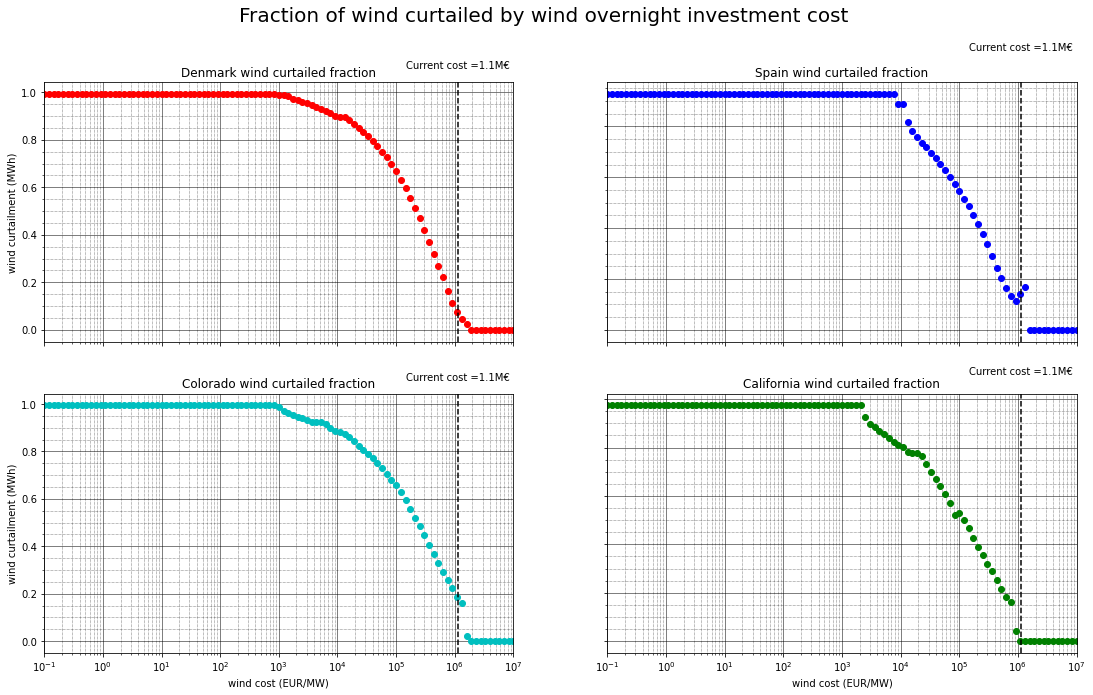

In [157]:

#This is our y axis. wc = wind curtailment
DNK_wc = list(map(abs, [x[4] for x in DNK_wind_data]))
ESP_wc = list(map(abs, [x[4] for x in ESP_wind_data]))
CAL_wc = list(map(abs, [x[4] for x in CAL_wind_data]))
CO_wc = list(map(abs, [x[4] for x in CO_wind_data]))




fig, axs = plt.subplots(2,2)
axs[0, 0].plot(w_cost, DNK_wc, 'ro')
axs[0, 0].set_title("Denmark wind curtailed fraction")
axs[0, 1].plot(w_cost, ESP_wc, 'bo')
axs[0, 1].set_title("Spain wind curtailed fraction")
axs[1, 0].plot(w_cost, CO_wc, 'co')
axs[1, 0].set_title("Colorado wind curtailed fraction")
axs[1, 1].plot(w_cost, CAL_wc, 'go')
axs[1, 1].set_title("California wind curtailed fraction")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_xlim(10**-1, 10**7)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='wind cost (EUR/MW)', ylabel='wind curtailment (MWh)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,1.1, "Current cost =1.1M€", horizontalalignment = "center")

plt.suptitle("Fraction of wind curtailed by wind overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/FracCurtailmentbyWindCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## 4. Variation by gas cost <a name="section-four"></a>

For completeness, we also want to run the same tests with gas cost

### 4.1 Running the optimization <a name="sub4.1"></a>

In [139]:
def find_gas_data(n, gas_cost):
    
    annualized_gas_cost = 0.08735510653063758 * gas_cost
    n.generators.loc[['OCGT'],['capital_cost']] = annualized_gas_cost
    #this substitutes the current wind cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    solar_penetration = n.generators_t.p['solar'].sum()/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()/sum(n.generators_t.p.sum())
    
    #The following determines system cost#
    systemcost = n.objective/n.loads_t.p.sum()
    
    #The following determines curtailment as a percent of generated capacity#
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['OCGT'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['OCGT'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    #first three in tuple are for penetration[0-2], then system cost[3]
    return (solar_penetration, wind_penetration, gas_penetration, systemcost, curtailment)




reset_stats(network)
reset_stats(nspain)
reset_stats(ncal)
reset_stats(nco)

#These four below return 100 points of cost vs solar penetration. 
DNK_gas_data = list(map(find_gas_data, repeat(network), np.logspace(0, 6, 5)))
ESP_gas_data = list(map(find_gas_data, repeat(nspain), np.logspace(0, 6, 5)))
CAL_gas_data = list(map(find_gas_data, repeat(ncal), np.logspace(0, 6, 5)))
CO_gas_data = list(map(find_gas_data, repeat(nco), np.logspace(0, 6, 5)))



print(DNK_gas_data[0:5])
print(ESP_gas_data[0:5])
print(CAL_gas_data[0:5])
print(CO_gas_data[0:5])

#print(end-start)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4emym9yb.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0e7b1aea
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4nh5xjjs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0ad9e847
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c43lagp5.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8d6357d6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-457awi6y.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x5009bb99
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m068zyha.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0a702f2c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.04e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u_vjwr2b.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x982db47a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-covzy7bi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xbe3e49a3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4s2sj13e.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xdbdd80dc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.16e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ayeycqu7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x40092a7f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7_yckuko.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x97a3259c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l8pps9yq.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa36653a5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_yg8wm00.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcf92ae05
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pg44bxfo.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xcc92c1e6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bi31tyui.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc7b925af
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bw575cho.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x945614b8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.08s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7t86xeoi.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x041d737b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [9e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wz2ga9gq.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x650d93a7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8gnxekq5.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7cacf154
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5nrj6s6s.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x73d67e9e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u0xn4d4k.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3f1de844
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.52e+09


[(0.08449625797663846, 0.43269375768793783, 0.4828099843354236, load    47.60127
dtype: float64, 0), (0.08449625797663846, 0.43269375768793783, 0.4828099843354236, load    47.601712
dtype: float64, 0), (0.08449625797663846, 0.43269375768793783, 0.4828099843354236, load    47.615685
dtype: float64, 0), (0.08444923001164503, 0.4329172458225248, 0.4826335241658302, load    48.057529
dtype: float64, 0), (0.08305044020096773, 0.4369844841254216, 0.4799650756736107, load    62.028426
dtype: float64, 0)]
[(0.3413453180191017, 0.0, 0.6586546819808984, load    46.84119
dtype: float64, 0), (0.3413453180191017, 0.0, 0.6586546819808984, load    46.841624
dtype: float64, 0), (0.3413453180191017, 0.0, 0.6586546819808984, load    46.855351
dtype: float64, 0), (0.3413453180191017, 0.0, 0.6586546819808984, load    47.289437
dtype: float64, 0), (0.29415278398678985, 0.15802790122369337, 0.5478193147895167, load    60.541413
dtype: float64, 0)]
[(0.365083824747841, 0.0, 0.6349161752521589, load    44.977

### 4.2 Graph of penetration <a name="sub4.2"></a>

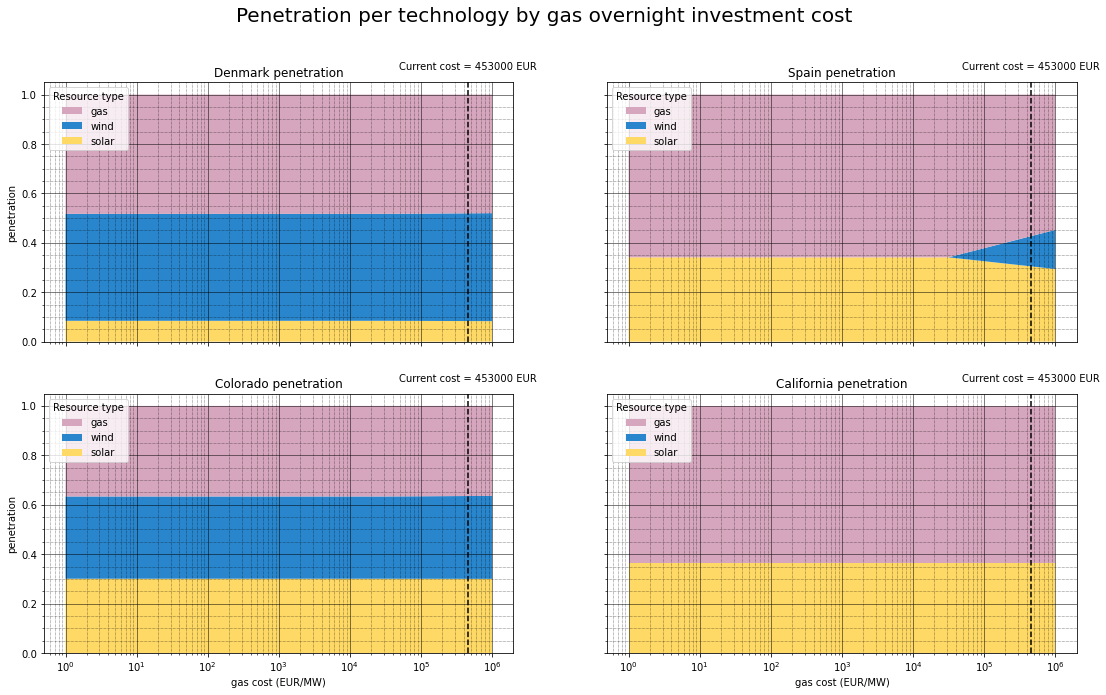

In [143]:
g_cost = np.logspace(0, 6, 5)

#This is our y axis. sp = solar penetration, wp = wind penetration, gp = gas penetration
DNK_spg = [x[0] for x in DNK_gas_data]
ESP_spg = [x[0] for x in ESP_gas_data]
CAL_spg = [x[0] for x in CAL_gas_data]
CO_spg = [x[0] for x in CO_gas_data]

DNK_wpg = [x[1] for x in DNK_gas_data]
ESP_wpg = [x[1] for x in ESP_gas_data]
CAL_wpg = [x[1] for x in CAL_gas_data]
CO_wpg = [x[1] for x in CO_gas_data]

DNK_gpg = [x[2] for x in DNK_gas_data]
ESP_gpg = [x[2] for x in ESP_gas_data]
CAL_gpg = [x[2] for x in CAL_gas_data]
CO_gpg = [x[2] for x in CO_gas_data]




fig, axs = plt.subplots(2,2)
axs[0, 0].stackplot(g_cost, DNK_spg, DNK_wpg, DNK_gpg, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 0].set_title("Denmark penetration")
axs[0, 1].stackplot(g_cost, ESP_spg, ESP_wpg, ESP_gpg, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 1].set_title("Spain penetration")
axs[1, 0].stackplot(g_cost, CO_spg, CO_wpg, CO_gpg, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 0].set_title("Colorado penetration")
axs[1, 1].stackplot(g_cost, CAL_spg, CAL_wpg, CAL_gpg, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 1].set_title("California penetration")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Resource type', loc='upper left')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='gas cost (EUR/MW)', ylabel='penetration')
#Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(453000, color='black',ls='--')
    ax.text(453000,1.1, "Current cost = 453000 EUR", horizontalalignment = "center")


plt.suptitle("Penetration per technology by gas overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/XLogPenetration for DNK, ESP, CAL, CO", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 4.3 Graph of System Cost <a name="sub4.3"></a>

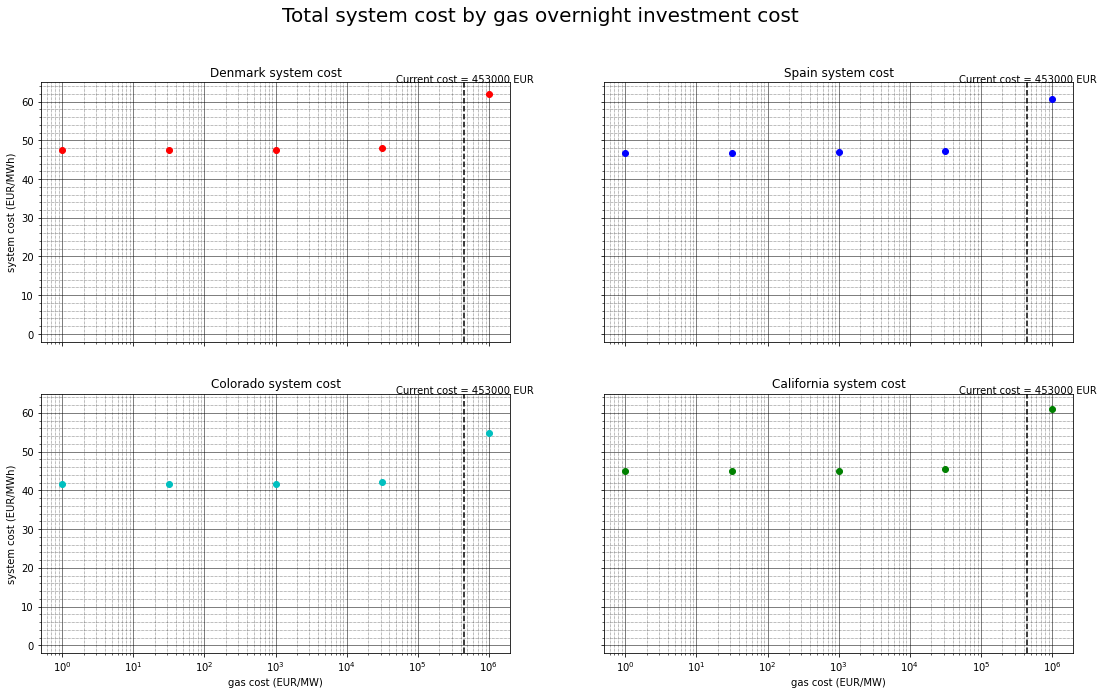

In [146]:
DNK_gcst = list(map(abs, [x[3] for x in DNK_gas_data]))
ESP_gcst = list(map(abs, [x[3] for x in ESP_gas_data]))
CAL_gcst = list(map(abs, [x[3] for x in CAL_gas_data]))
CO_gcst = list(map(abs, [x[3] for x in CO_gas_data]))



fig, axs = plt.subplots(2,2)
axs[0, 0].plot(g_cost, DNK_gcst, 'ro')
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(g_cost, ESP_gcst, 'bo')
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(g_cost, CO_gcst, 'co')
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(g_cost, CAL_gcst, 'go')
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_ylim(-2, 65)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='gas cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(453000, color='black',ls='--')
    ax.text(453000,65, "Current cost = 453000 EUR", horizontalalignment = "center")

plt.suptitle("Total system cost by gas overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/System Cost by wind costXLog", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 4.4 Graph of curtailment percent <a name="sub4.4"></a>

Obviously, this plot is not that interesting

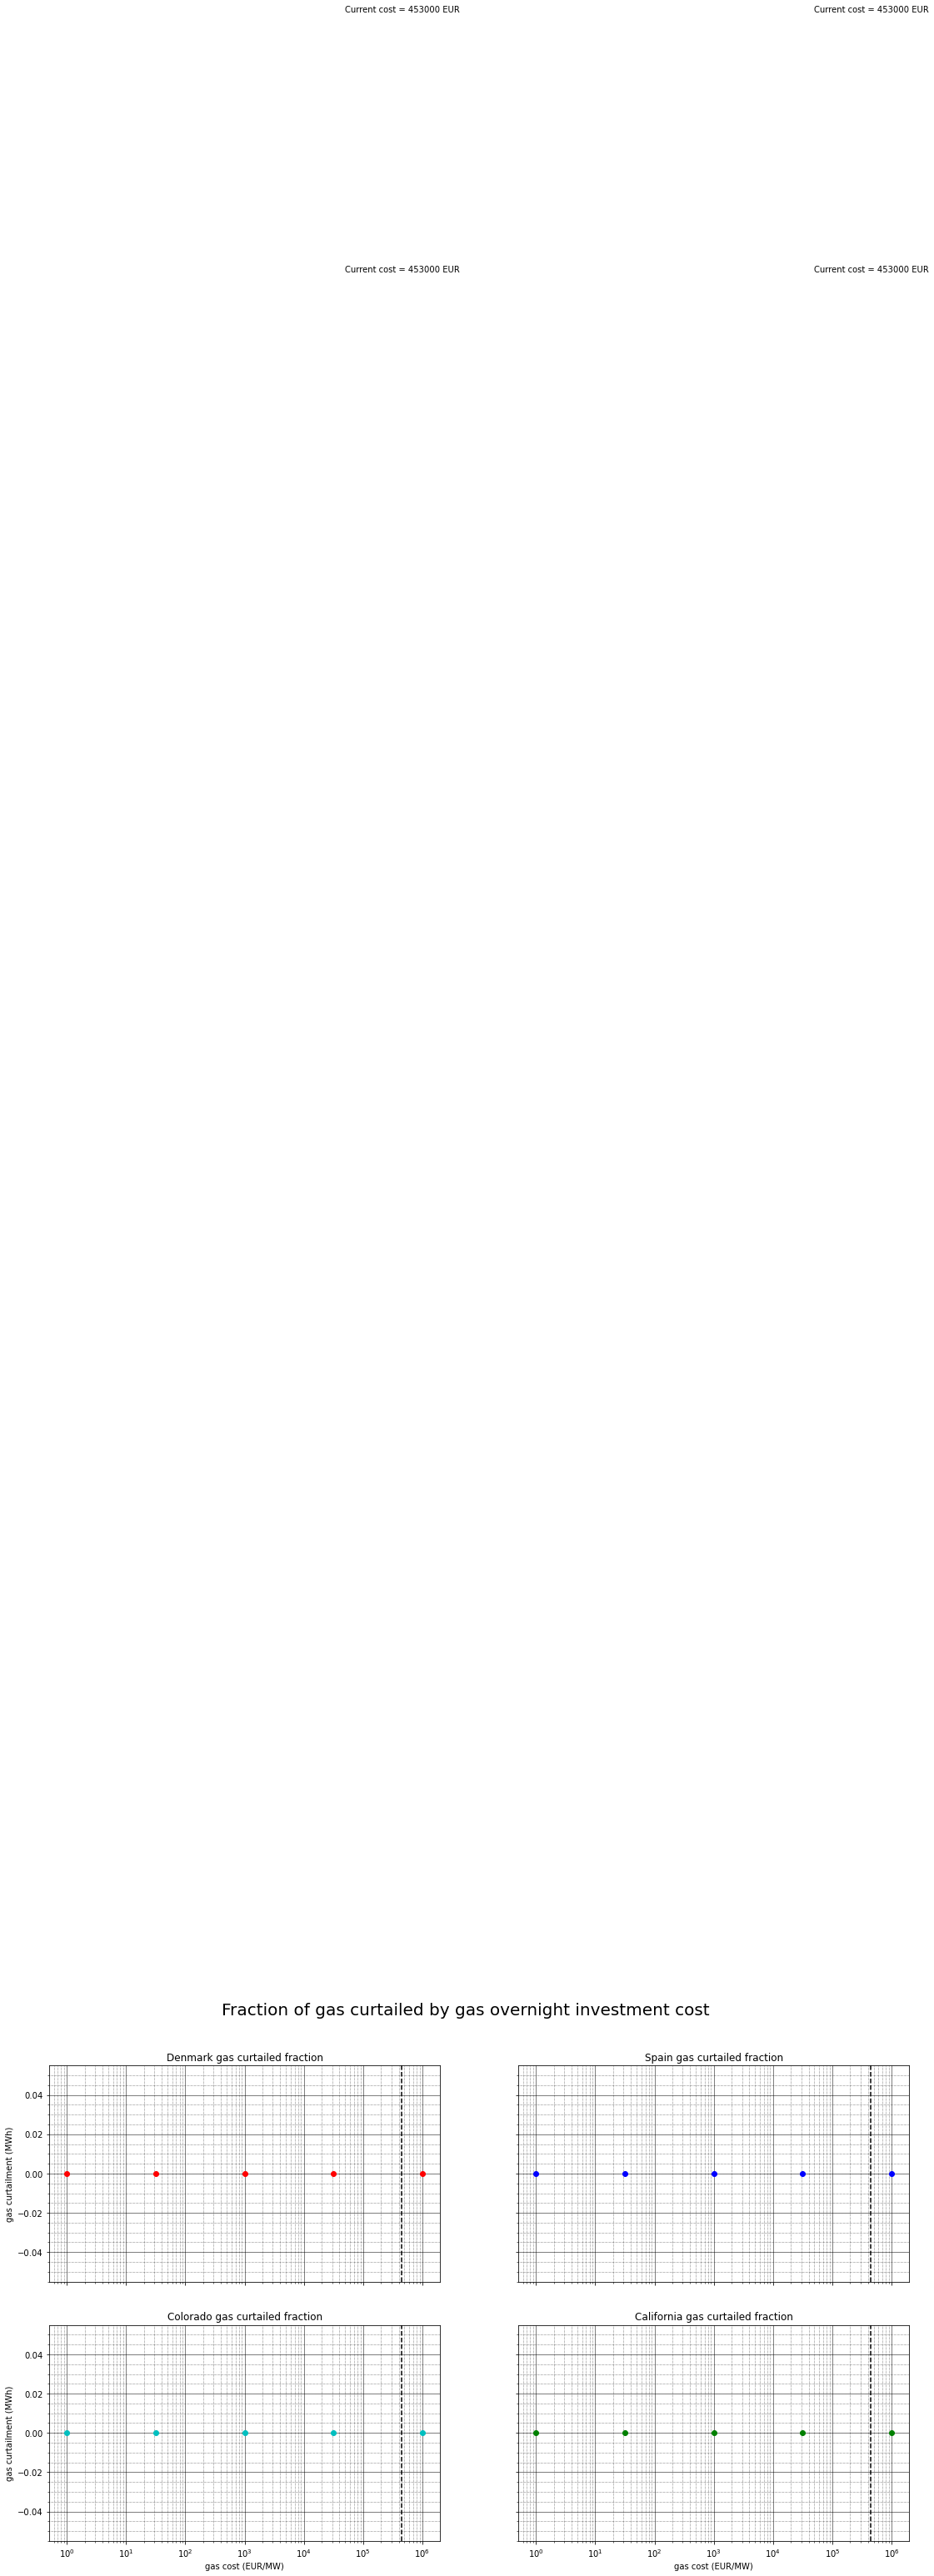

In [145]:
DNK_gc = list(map(abs, [x[4] for x in DNK_gas_data]))
ESP_gc = list(map(abs, [x[4] for x in ESP_gas_data]))
CAL_gc = list(map(abs, [x[4] for x in CAL_gas_data]))
CO_gc = list(map(abs, [x[4] for x in CO_gas_data]))




fig, axs = plt.subplots(2,2)
axs[0, 0].plot(g_cost, DNK_gc, 'ro')
axs[0, 0].set_title("Denmark gas curtailed fraction")
axs[0, 1].plot(g_cost, ESP_gc, 'bo')
axs[0, 1].set_title("Spain gas curtailed fraction")
axs[1, 0].plot(g_cost, CO_gc, 'co')
axs[1, 0].set_title("Colorado gas curtailed fraction")
axs[1, 1].plot(g_cost, CAL_gc, 'go')
axs[1, 1].set_title("California gas curtailed fraction")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='gas cost (EUR/MW)', ylabel='gas curtailment (MWh)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(453000, color='black',ls='--')
    ax.text(453000,1.1, "Current cost = 453000 EUR", horizontalalignment = "center")

plt.suptitle("Fraction of gas curtailed by gas overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/FracSolar curtailment wind var XLog", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## 5. Mismatch curve for renewables <a name="section-five"></a>

We want to see the mismatch curve for renewable technologies when the prices are low--what do those curtailment curves actually look like? How many hours are curtailed, how many hours is there a deficit, and what are the magnitudes of each?

To answer this question, we create a function that does the following: optimize a network for a certain solar/wind price. Take the time series of solar/wind generation and subtract from it the electrical load for each time step, creating a new array. Then, we will sort the values descending, and plot magnitude by 8760 hours.

### 5.1 Solar mismatch <a name="sub5.1"></a>

In [103]:
mynetworks = [network, nspain, ncal, nco]
network_names = ['Denmark', 'Spain', 'California', 'Colorado']

We start by finding the mismatch of solar for a given cost. Then, we have a function that puts the solar mismatches of every region for that cost into a data table. We sort this mismatch by each column individually, and make one plot of all four regions at each cost point.

In [148]:


for n in mynetworks:
    reset_stats(n)
    
#This function finds the mismatch at each timestep for a network n
def find_sol_mismatch(n, solar_cost):
    #as always, we start by solving
    annualized_solar_cost =  0.07846970300338728* solar_cost
    n.generators.loc[['solar'],['capital_cost']] = annualized_solar_cost
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    mismatch = pd.DataFrame()
    
    mismatch['solar mismatch'] = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar']-n.loads_t.p.load
    
    mismatch = mismatch.set_index([list(range(8760))])
    #This actually isn't plotting our mismatch--this is plotting the difference between
    #the contribution of solar and the total load. Sometimes this can equal the total 
    #load, but it can never go above the total load. We are interested in the difference 
    #between the capacity of solar generation and the demand.
    
    #Will there be a difference in renewable energy mismatch and 
    #mismatch['solar mismatch'] = n.generators_t.p.solar - n.loads_t.p.load
    
    return mismatch

#print(find_sol_mismatch(network, 100000))

#This function uses the previous function and loops over every network to make one
#dataframe with mismatches of every region
def all_region_mismatch(cost):
    
    mismatches = pd.DataFrame()

#if we want to use the network names as the names of the columns, we need a separate
#list with them as strings. Then, we use the index of each network in mynetwork to link
#the two lists.
    for n in mynetworks:
        mismatches[network_names[mynetworks.index(n)]] = find_sol_mismatch(n, cost)['solar mismatch']
        
    return mismatches


#This function sorts each column individually to return four sorted columns
def sort_mismatch(function, cost):
    
    df = all_region_mismatch(cost)
    
    for col in df.columns:
        df[col] = df[col].sort_values(ascending = False).values
    
    return df



#df = sort_mismatch(10000)


#what is the actual electricity load series? network.loads_t.p
#The time series for generators are:
#n.generators_t.p['solar']
#n.generators_t.p['onshorewind']

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-r3vdcbqw.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xad1c7302
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43706 rows and 17427 columns
Presolve time: 0.05s
Presolved: 17614 rows, 8857 columns, 35275 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.642e+04
 Factor NZ  : 6.203e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.238e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2ns8dsas.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa9278b8a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43670 rows and 17391 columns
Presolve time: 0.06s
Presolved: 17650 rows, 8893 columns, 35365 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.648e+04
 Factor NZ  : 6.230e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.256e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hdwpyesy.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6fcd9095
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43694 rows and 17415 columns
Presolve time: 0.05s
Presolved: 17626 rows, 8869 columns, 35305 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.644e+04
 Factor NZ  : 6.212e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.244e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ckq4bfld.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd064a2b4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43730 rows and 17451 columns
Presolve time: 0.06s
Presolved: 17590 rows, 8833 columns, 35215 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.638e+04
 Factor NZ  : 6.185e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.225e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.11e+09


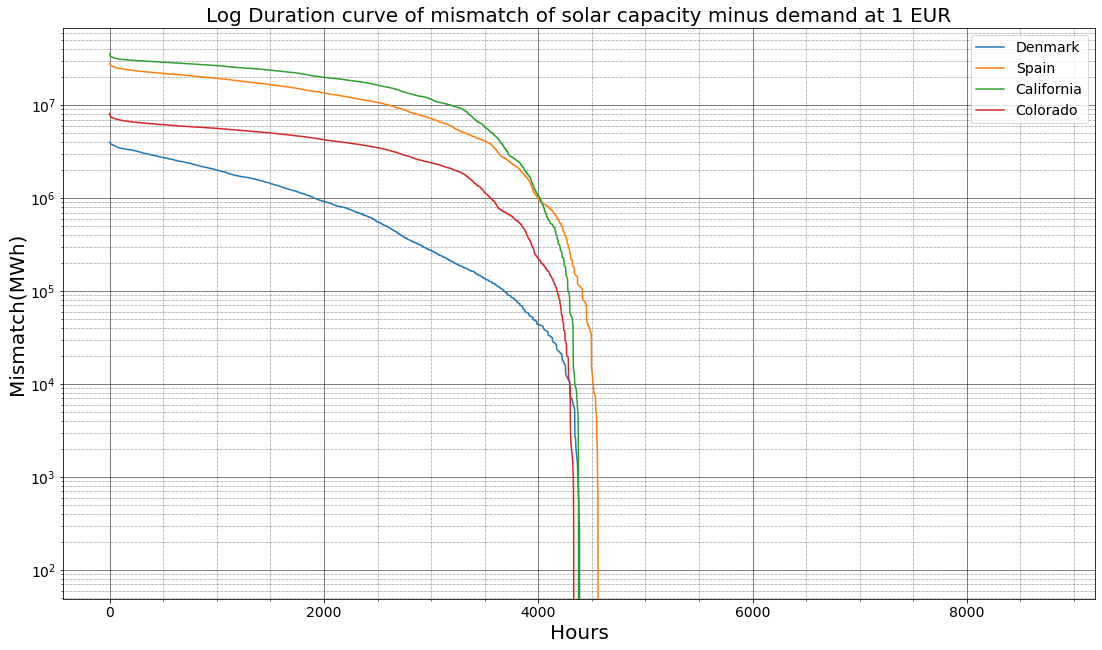

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u1ouilzs.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa884074d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42682 rows and 16403 columns
Presolve time: 0.06s
Presolved: 18638 rows, 9881 columns, 37835 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.796e+04
 Factor NZ  : 6.971e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.755e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-766gv5gd.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x41907402
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43130 rows and 16851 columns
Presolve time: 0.06s
Presolved: 18190 rows, 9433 columns, 36715 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.728e+04
 Factor NZ  : 6.635e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.528e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.74e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x1yd0a6m.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfe71a8c5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43224 rows and 16945 columns
Presolve time: 0.06s
Presolved: 18096 rows, 9339 columns, 36480 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.714e+04
 Factor NZ  : 6.565e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.481e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-liathvfz.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9fd51668
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43428 rows and 17149 columns
Presolve time: 0.06s
Presolved: 17892 rows, 9135 columns, 35970 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.684e+04
 Factor NZ  : 6.412e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.378e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+09


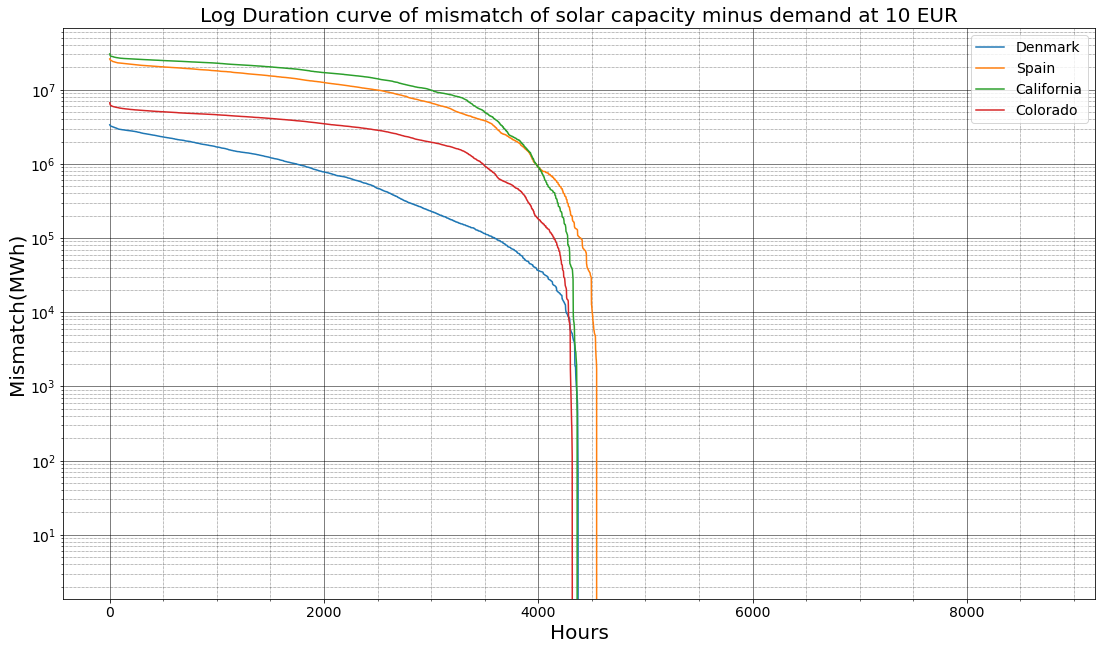

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-osazhf64.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfa0ca853
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 39558 rows and 13279 columns
Presolve time: 0.07s
Presolved: 21762 rows, 13005 columns, 45645 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.264e+04
 Factor NZ  : 9.314e+04 (roughly 15 MBytes of memory)
 Factor Ops : 4.332e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-783wqhq0.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x946b079a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41316 rows and 15037 columns
Presolve time: 0.07s
Presolved: 20004 rows, 11247 columns, 41250 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.001e+04
 Factor NZ  : 7.996e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.445e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 7.88e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4pznnd20.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x4ac95dc2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42006 rows and 15727 columns
Presolve time: 0.06s
Presolved: 19314 rows, 10557 columns, 39525 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.897e+04
 Factor NZ  : 7.478e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.096e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rmkg7i4w.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd1cb771c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42074 rows and 15795 columns
Presolve time: 0.06s
Presolved: 19246 rows, 10489 columns, 39355 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.887e+04
 Factor NZ  : 7.427e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.062e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e+09


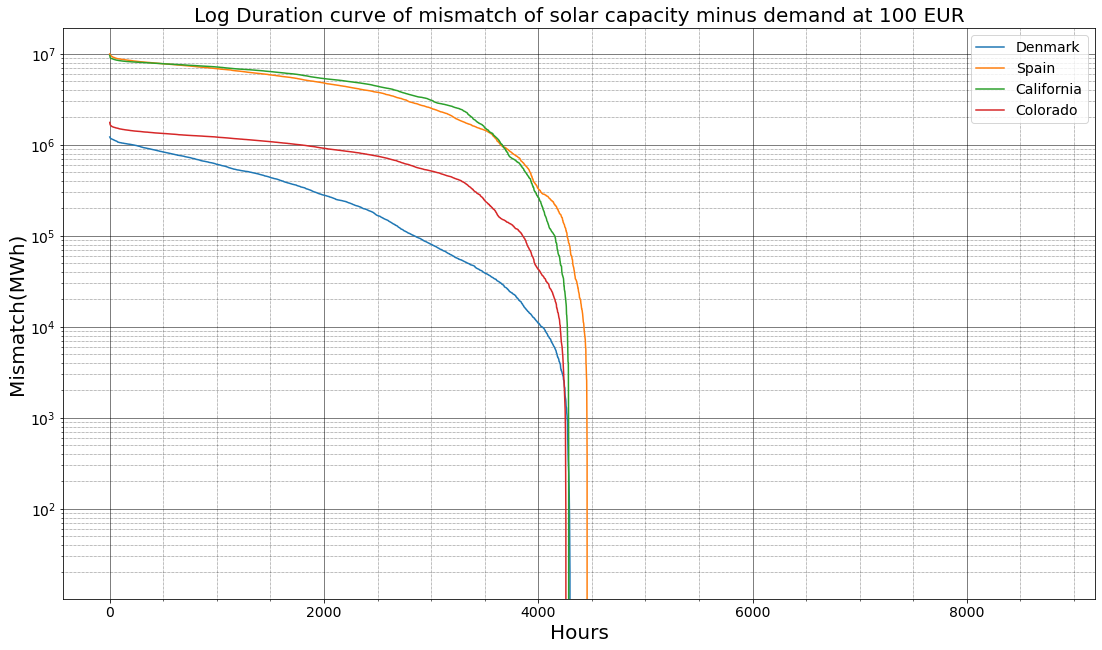

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yjfzm5hn.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xaf57f6af
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-izgy2dz_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5778d6c1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6w28zjtl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5a45f98f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ugulyy3y.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xbfc4084d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.19e+09


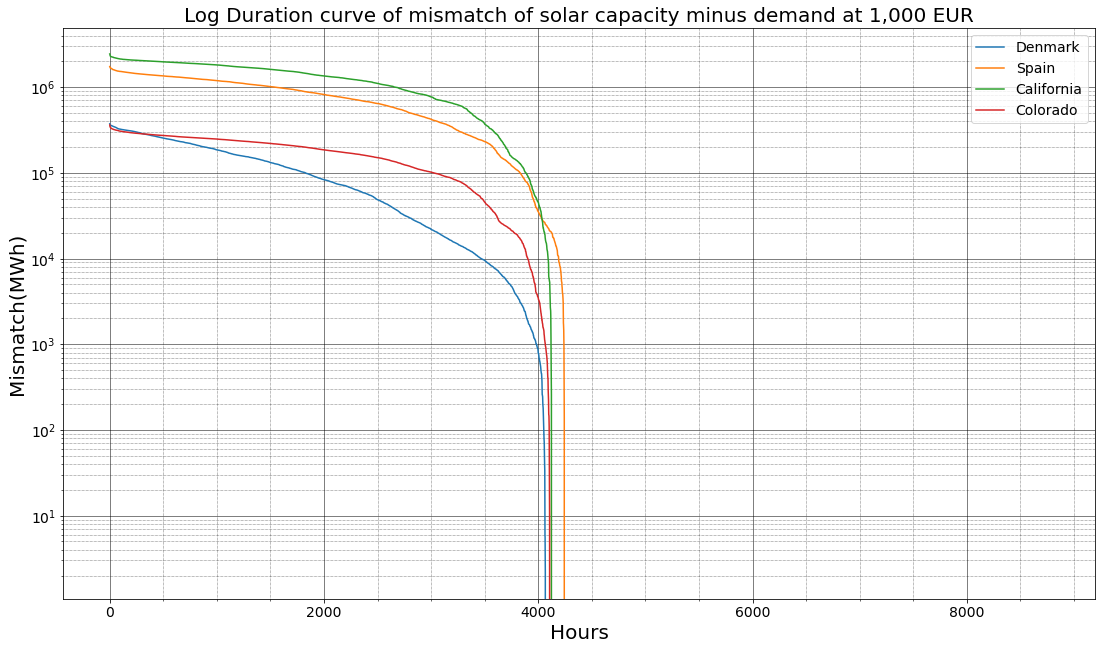

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sz24k3fi.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc25535b3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2kya33xn.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9ff06e15
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.89e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-le65k07v.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa87bb522
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ws9aqc5a.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xa281a3d9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.31e+09


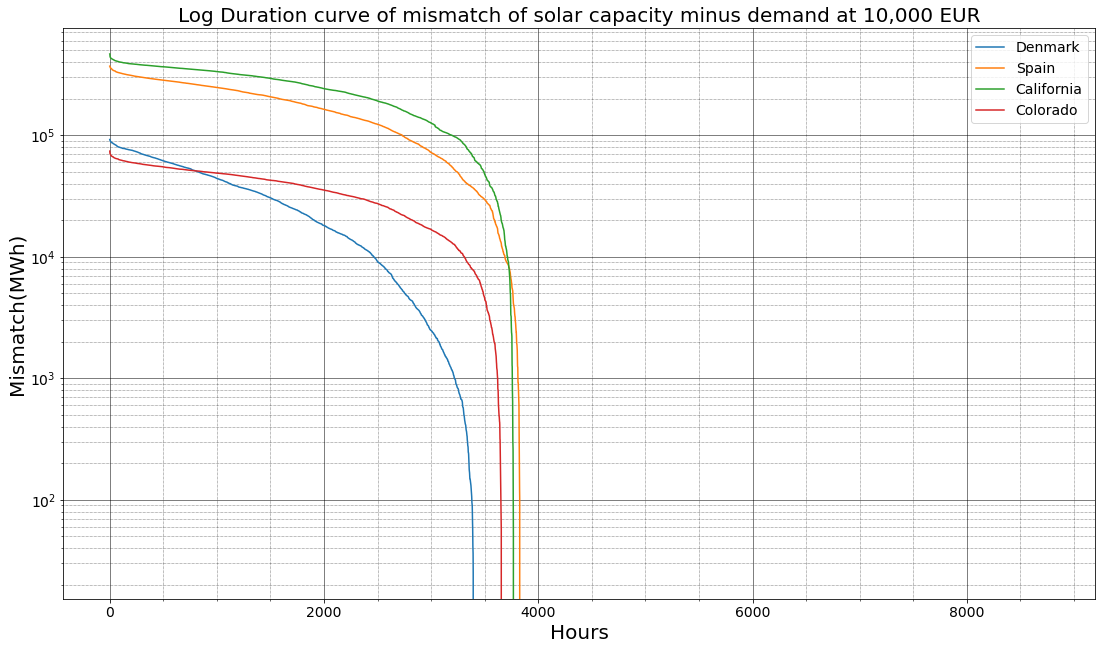

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kb427sji.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf3b1e50e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zsa2itrt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6165e6b7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k7yr0wxk.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xbdef4901
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8dgvo25i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xafafde68
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e+09


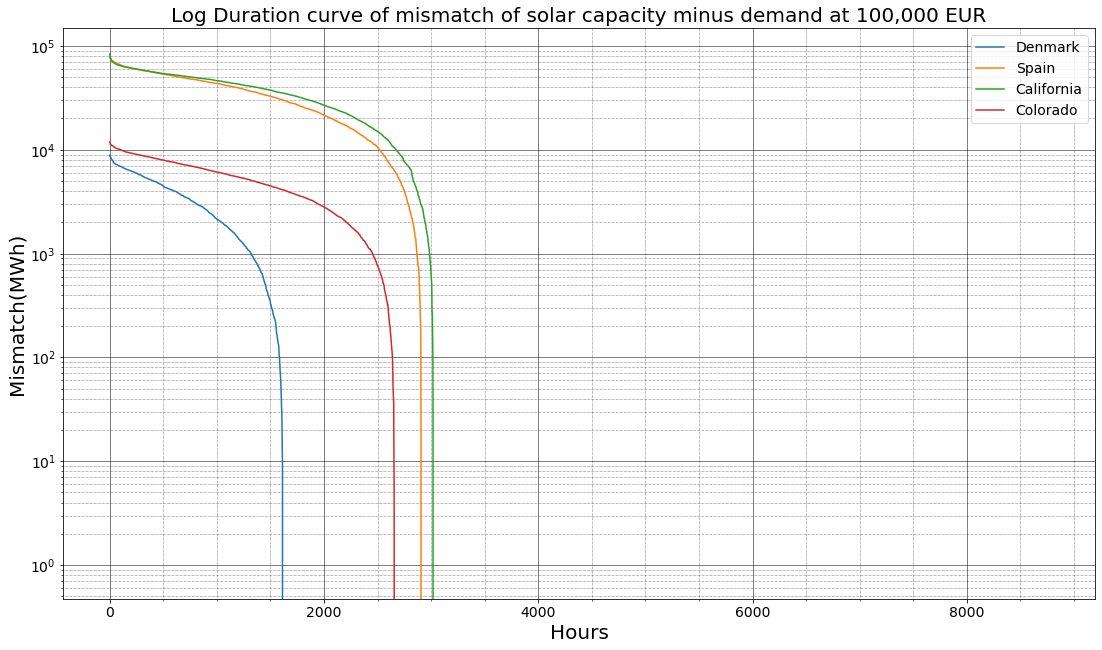

In [143]:
def make_fig(cost):
    df = sort_mismatch(cost)
    
    fig, ax = plt.subplots()
    plt.plot(df.index, df[network_names])

    ax.minorticks_on()

    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set_title("Log Duration curve of mismatch of solar capacity minus demand at "+ format(int(cost), ',') +" EUR", size = '20')
    ax.set_xlabel("Hours", fontsize = 20)
    ax.set_ylabel("Mismatch(MWh)", fontsize = 20)
    ax.set_yscale('log')
    

    plt.legend(network_names, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    fig = plt.gcf()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(18.5, 10.5)
    
    plt.savefig("Images/MismatchDurationCurve10^"+str(int(np.log10(cost)))+"EUR_LogPlot")
    plt.show()
    return
 
#for i in np.logspace(0, 5, 6):
#    make_fig(i)
print(sort_mismatch([10, 100]))


What if we want to compare cost points within a single region? In this case, we calculate the mismatch at each cost point for a single network and make the columns of a data frame these values. We then sort, and plot each column like before, except that now we have costs as the variable instead of the region.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-o_cigj4z.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xad1c7302
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43706 rows and 17427 columns
Presolve time: 0.06s
Presolved: 17614 rows, 8857 columns, 35275 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.642e+04
 Factor NZ  : 6.203e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.238e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6zl8hifj.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa884074d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42682 rows and 16403 columns
Presolve time: 0.06s
Presolved: 18638 rows, 9881 columns, 37835 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.796e+04
 Factor NZ  : 6.971e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.755e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-azf8hu76.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfa0ca853
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 39558 rows and 13279 columns
Presolve time: 0.07s
Presolved: 21762 rows, 13005 columns, 45645 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.264e+04
 Factor NZ  : 9.314e+04 (roughly 15 MBytes of memory)
 Factor Ops : 4.332e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tw5t16p6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xaf57f6af
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q764yf6q.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc25535b3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f14l6oba.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf3b1e50e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+09


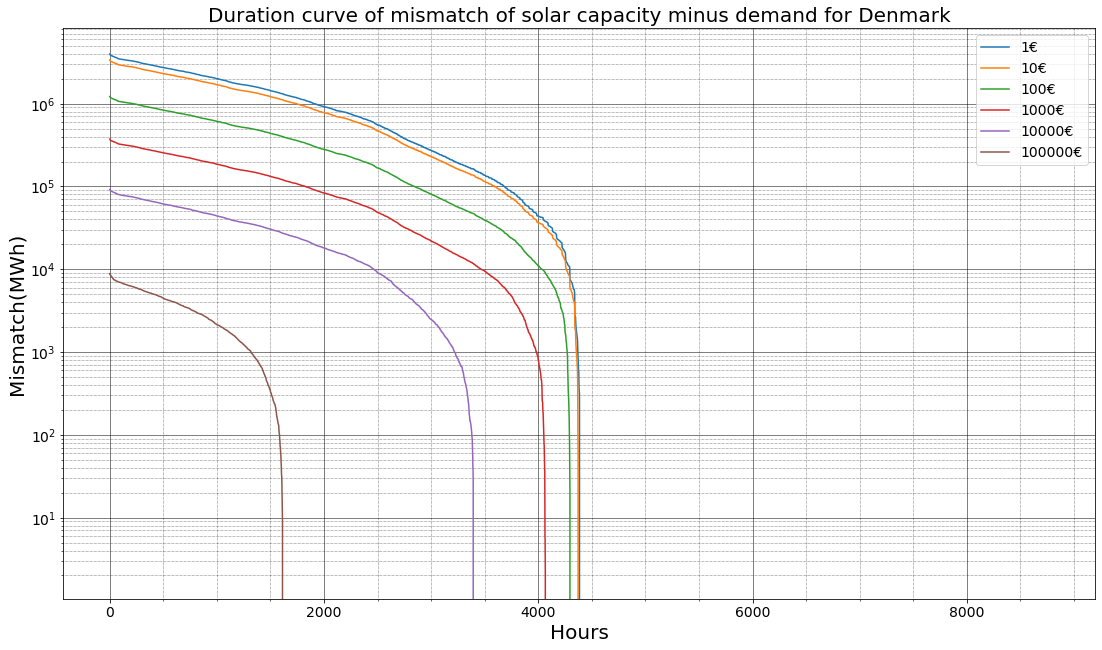

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qtbcpefk.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa9278b8a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43670 rows and 17391 columns
Presolve time: 0.07s
Presolved: 17650 rows, 8893 columns, 35365 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.648e+04
 Factor NZ  : 6.230e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.256e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qgs2cary.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x41907402
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43130 rows and 16851 columns
Presolve time: 0.06s
Presolved: 18190 rows, 9433 columns, 36715 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.728e+04
 Factor NZ  : 6.635e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.528e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.74e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5sw3eevq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x946b079a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 41316 rows and 15037 columns
Presolve time: 0.06s
Presolved: 20004 rows, 11247 columns, 41250 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.001e+04
 Factor NZ  : 7.996e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.445e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 7.88e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s2d_0nvh.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x5778d6c1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-72gvovow.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9ff06e15
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.89e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b1g79edp.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6165e6b7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+10


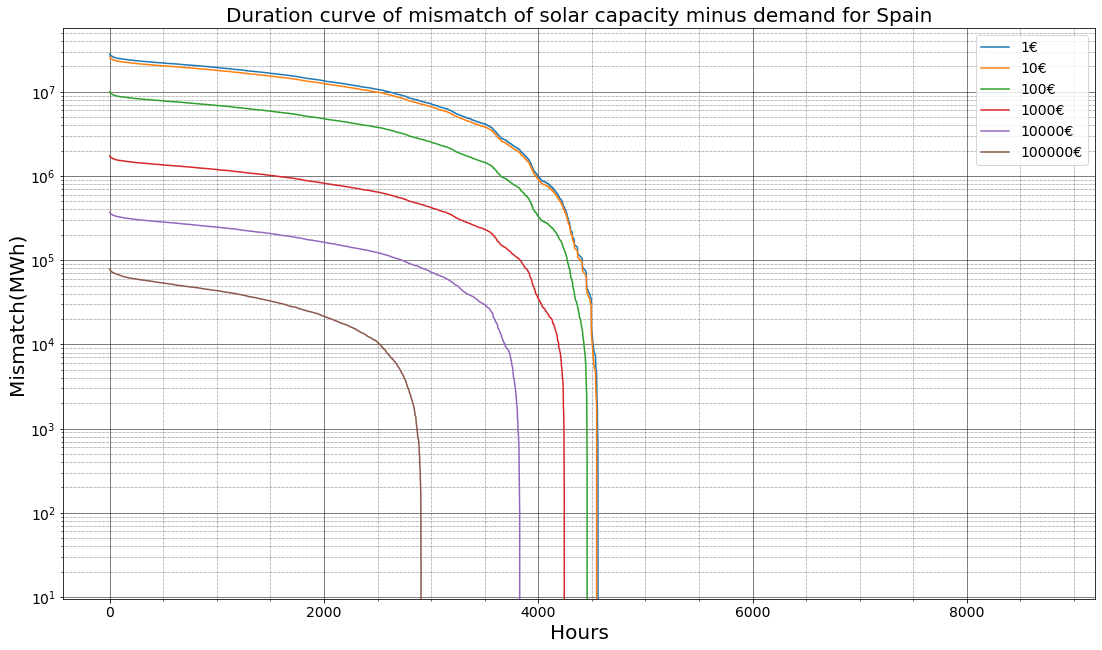

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0ktc_fns.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x6fcd9095
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43694 rows and 17415 columns
Presolve time: 0.06s
Presolved: 17626 rows, 8869 columns, 35305 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.644e+04
 Factor NZ  : 6.212e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.244e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8z9w9ni1.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfe71a8c5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43224 rows and 16945 columns
Presolve time: 0.06s
Presolved: 18096 rows, 9339 columns, 36480 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.714e+04
 Factor NZ  : 6.565e+04 (roughly 12 MBytes of memory)
 Factor Ops : 2.481e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t5tu66wt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x4ac95dc2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42006 rows and 15727 columns
Presolve time: 0.06s
Presolved: 19314 rows, 10557 columns, 39525 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.897e+04
 Factor NZ  : 7.478e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.096e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yay7duyt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5a45f98f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tad69laf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa87bb522
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5p3j36p2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xbdef4901
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+10


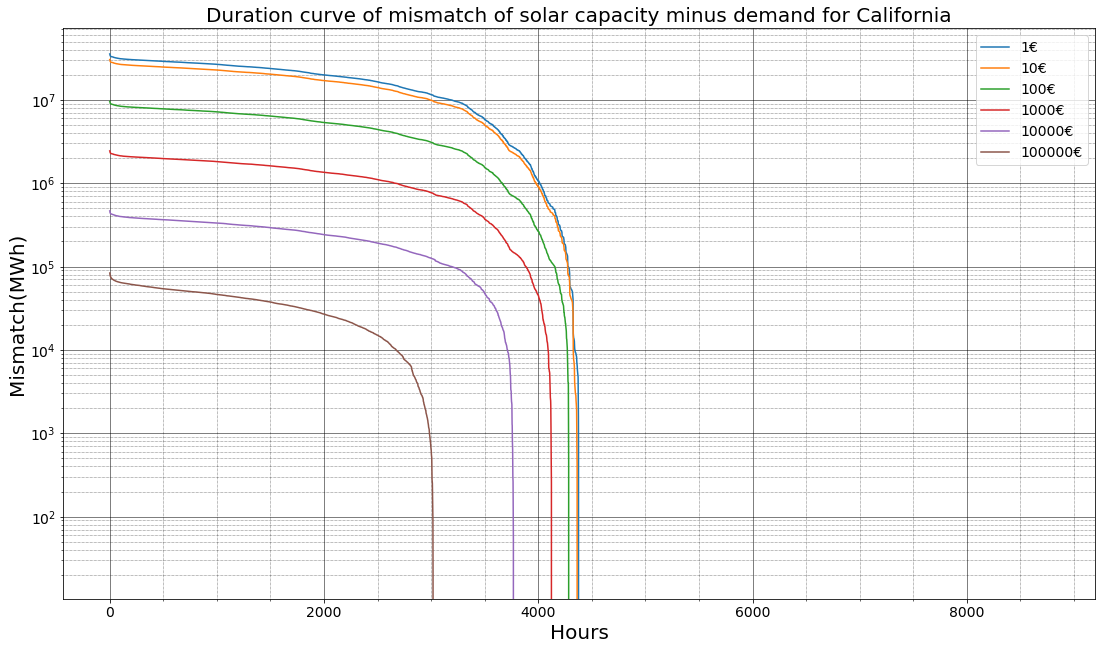

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5jzfxi2p.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd064a2b4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43730 rows and 17451 columns
Presolve time: 0.08s
Presolved: 17590 rows, 8833 columns, 35215 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.638e+04
 Factor NZ  : 6.185e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.225e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.11e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pts0qstn.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9fd51668
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43428 rows and 17149 columns
Presolve time: 0.07s
Presolved: 17892 rows, 9135 columns, 35970 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.684e+04
 Factor NZ  : 6.412e+04 (roughly 11 MBytes of memory)
 Factor Ops : 2.378e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sxyyf6j7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd1cb771c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 42074 rows and 15795 columns
Presolve time: 0.06s
Presolved: 19246 rows, 10489 columns, 39355 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.887e+04
 Factor NZ  : 7.427e+04 (roughly 13 MBytes of memory)
 Factor Ops : 3.062e+05 (less than 1 second per iteration)
 Threads    : 1

                

INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ombny9vs.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xbfc4084d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.19e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-iw7qppnp.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xa281a3d9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-58leug1n.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xafafde68
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.09s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.56e+09


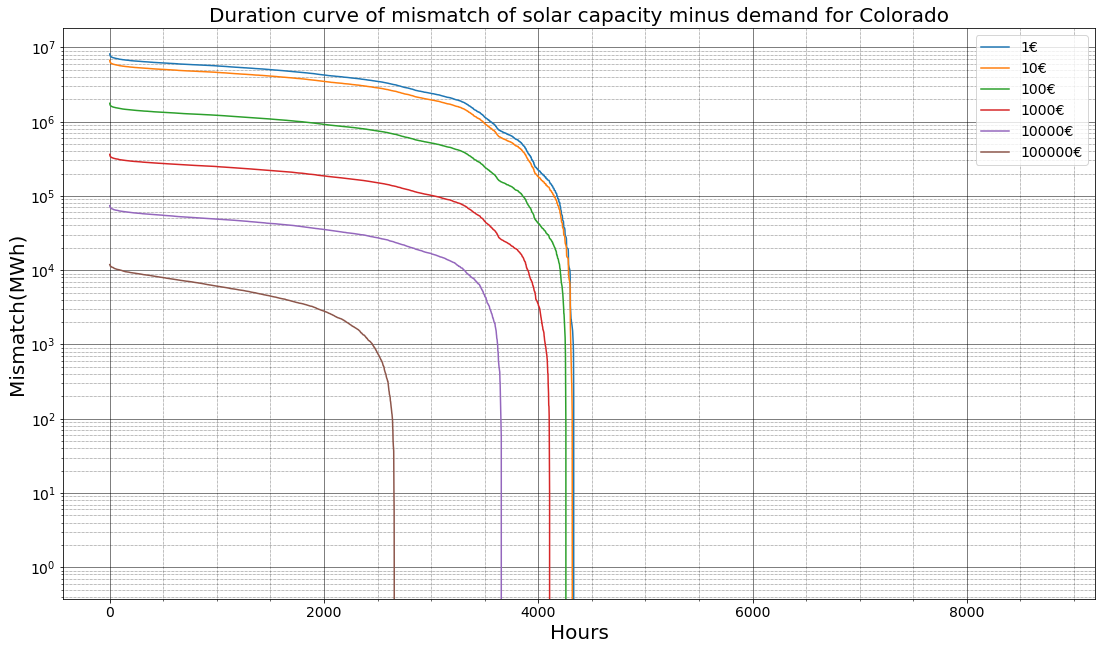

In [159]:
def same_region_mismatch(n, powers):
    plotrange = np.logspace(0, powers, powers+1)
    mismatches = pd.DataFrame()
    for number in plotrange:
        mismatches[str(int(number))+'EUR'] = find_sol_mismatch(n, number)['solar mismatch']
    for col in mismatches.columns:
        mismatches[col] = mismatches[col].sort_values(ascending = False).values
    return mismatches




def make_regional_fig(n, powers):
    df = same_region_mismatch(n, powers)
    fig, ax = plt.subplots()
    plt.plot(df.index, df[list(df.columns.values)])

    ax.minorticks_on()

    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set_title("Duration curve of mismatch of solar capacity minus demand for "+ network_names[mynetworks.index(n)], size = '20')
    ax.set_xlabel("Hours", fontsize = 20)
    ax.set_ylabel("Mismatch(MWh)", fontsize = 20)
    ax.set_yscale('log')
    
    myrange = np.logspace(0, powers, powers+1)
    mystrings = [str(int(x))+ "€" for x in myrange]
    
    plt.legend(mystrings, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    fig = plt.gcf()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(18.5, 10.5)
    
    plt.savefig("Images/RegionalMismatchDurationCurve"+network_names[mynetworks.index(n)]+"LogScale")
    plt.show()
    return

for n in mynetworks:
    make_regional_fig(n, 5)

### 5.2 Wind Mismatch <a name="sub5.2"></a>

The plots for wind are made in much the same way as solar. We find the mismatches and make columns of one data table  the values we get for a certain region for one datapoint.

In [164]:

for n in mynetworks:
    reset_stats(n)
    
#This function finds the mismatch at each timestep for a network n
def find_wind_mismatch(n, wind_cost):
    #as always, we start by solving
    annualized_wind_cost =  0.08442684282600257* wind_cost
    n.generators.loc[['onshorewind'],['capital_cost']] = annualized_wind_cost
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    mismatch = pd.DataFrame()
    
    mismatch['wind mismatch'] = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind']-n.loads_t.p.load
    
    mismatch = mismatch.set_index([list(range(8760))])
    #This actually isn't plotting our mismatch--this is plotting the difference between
    #the contribution of solar and the total load. Sometimes this can equal the total 
    #load, but it can never go above the total load. We are interested in the difference 
    #between the capacity of solar generation and the demand.
    
    #Will there be a difference in renewable energy mismatch and 
    #mismatch['solar mismatch'] = n.generators_t.p.solar - n.loads_t.p.load
    
    return mismatch

#print(find_sol_mismatch(network, 100000))

#This function uses the previous function and loops over every network to make one
#dataframe with mismatches of every region
def all_region_wind_mismatch(cost):
    
    mismatches = pd.DataFrame()

#if we want to use the network names as the names of the columns, we need a separate
#list with them as strings. Then, we use the index of each network in mynetwork to link
#the two lists.
    for n in mynetworks:
        mismatches[network_names[mynetworks.index(n)]] = find_wind_mismatch(n, cost)['wind mismatch']
        
    return mismatches


#This function sorts each column individually to return four sorted columns
def sort_wind_mismatch(cost):
    
    df = all_region_wind_mismatch(cost)
    
    for col in df.columns:
        df[col] = df[col].sort_values(ascending = False).values
    
    return df



#df = sort_mismatch(10000)


#what is the actual electricity load series? network.loads_t.p
#The time series for generators are:
#n.generators_t.p['solar']
#n.generators_t.p['onshorewind']

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tf1_zi9a.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xdd3327ac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.49e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-na_n0lgn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2b40c06c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6s14kcda.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01efc3b9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v241rx7m.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7a118f74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09


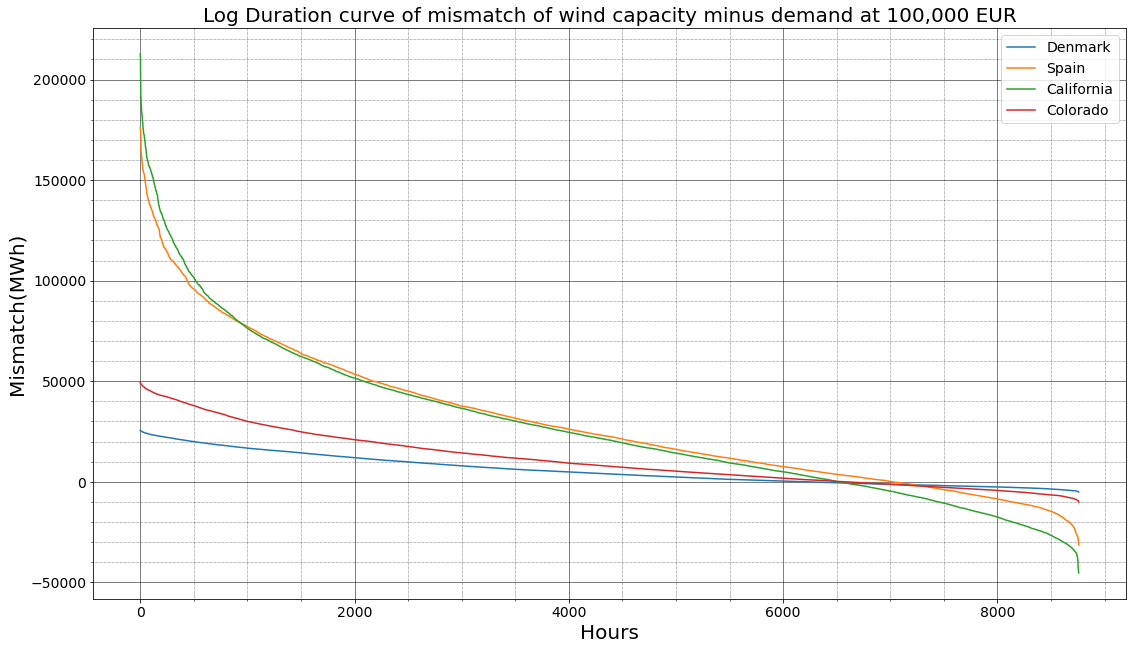

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fixoc8r3.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x1417bc62
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.08s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-mne9g6wt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x784d12fa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fybufe21.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xffeeac60
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zcwp3pas.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xafabafae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+09


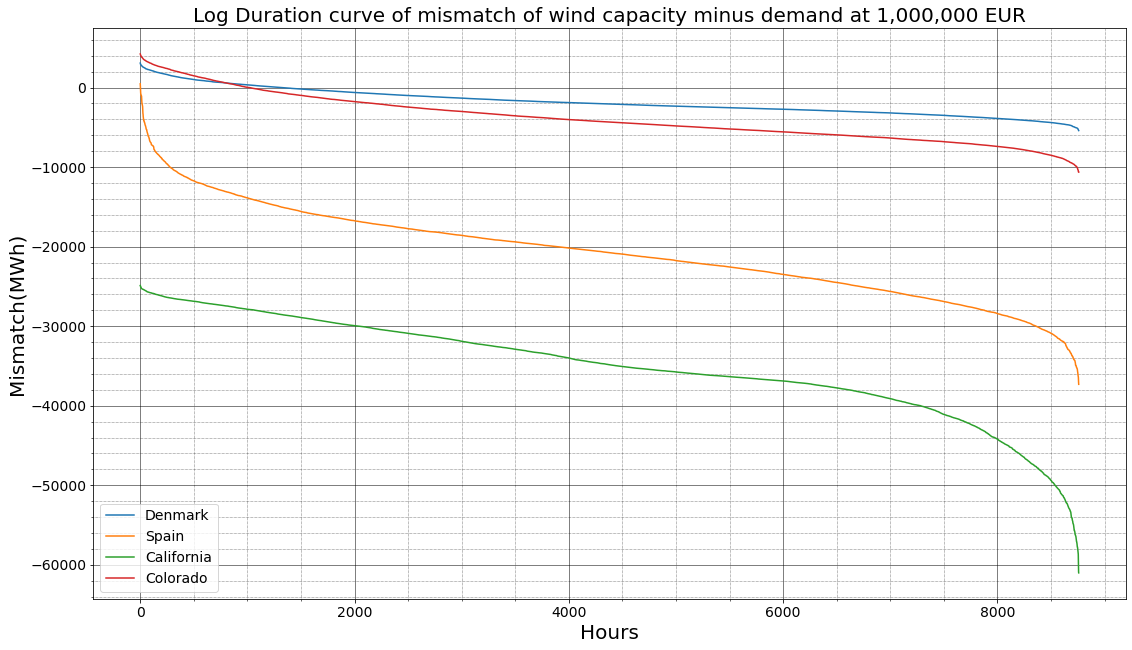

In [170]:
def make_wind_fig(cost):
    df = sort_wind_mismatch(cost)
    
    fig, ax = plt.subplots()
    plt.plot(df.index, df[network_names])

    ax.minorticks_on()

    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set_title("Log Duration curve of mismatch of wind capacity minus demand at "+ format(int(cost), ',') +" EUR", size = '20')
    ax.set_xlabel("Hours", fontsize = 20)
    ax.set_ylabel("Mismatch(MWh)", fontsize = 20)
    
    

    plt.legend(network_names, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    fig = plt.gcf()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(18.5, 10.5)
    
    plt.savefig("Images/WindMismatchDurationCurve10^"+str(int(np.log10(cost)))+"EUR")
    plt.show()
    return
 
make_wind_fig(10**5)
make_wind_fig(10**6)



Again, for comparison within a single region, we calculate the mismatch at each cost point for a single network, sort them, and plot on one graph.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v_5biact.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfc806444
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 26284 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4501899e+05   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.07 seconds
Optimal objective  1.450189915e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-azegolij.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd82bf04b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60536 rows and 25724 columns
Presolve time: 0.05s
Presolved: 784 rows, 560 columns, 1733 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.176e+03
 Factor NZ  : 4.070e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.235e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objec

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2lgem8co.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x87fcfc3f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 52554 rows and 20259 columns
Presolve time: 0.06s
Presolved: 8766 rows, 6025 columns, 19171 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.315e+04
 Factor NZ  : 4.380e+04 (roughly 6 MBytes of memory)
 Factor Ops : 2.342e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ekdwjeiw.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x04e90c3b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k8zzxr77.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x317ba7b7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.32e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ida9i1uo.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xdd3327ac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.49e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-09240dic.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x1417bc62
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+09


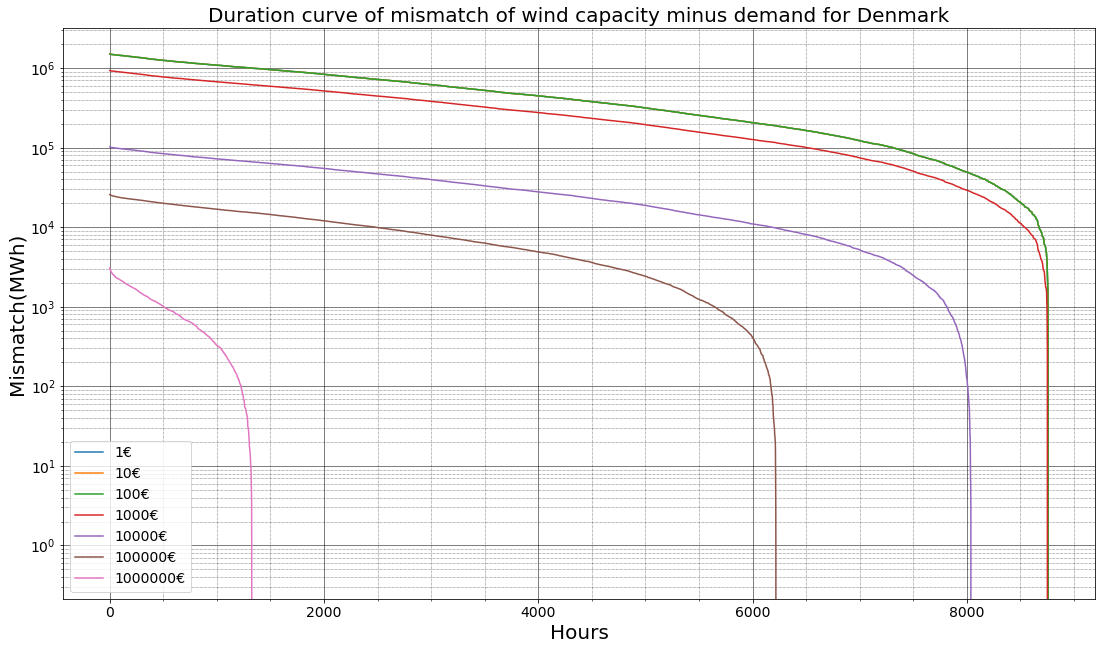

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-93rdf85z.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x89c4edf7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qq__x86d.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6d85c4aa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61316 rows and 26280 columns
Presolve time: 0.05s
Presolved: 4 rows, 4 columns, 8 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal     

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kx2tvyls.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x61b9f1cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 54032 rows and 21382 columns
Presolve time: 0.06s
Presolved: 7288 rows, 4902 columns, 15831 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.093e+04
 Factor NZ  : 3.555e+04 (roughly 5 MBytes of memory)
 Factor Ops : 1.865e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8y2aamxc.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xfb07f95d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5yg4dx3_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe1169556
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ns1rll7q.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2b40c06c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q76iuup3.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x784d12fa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10


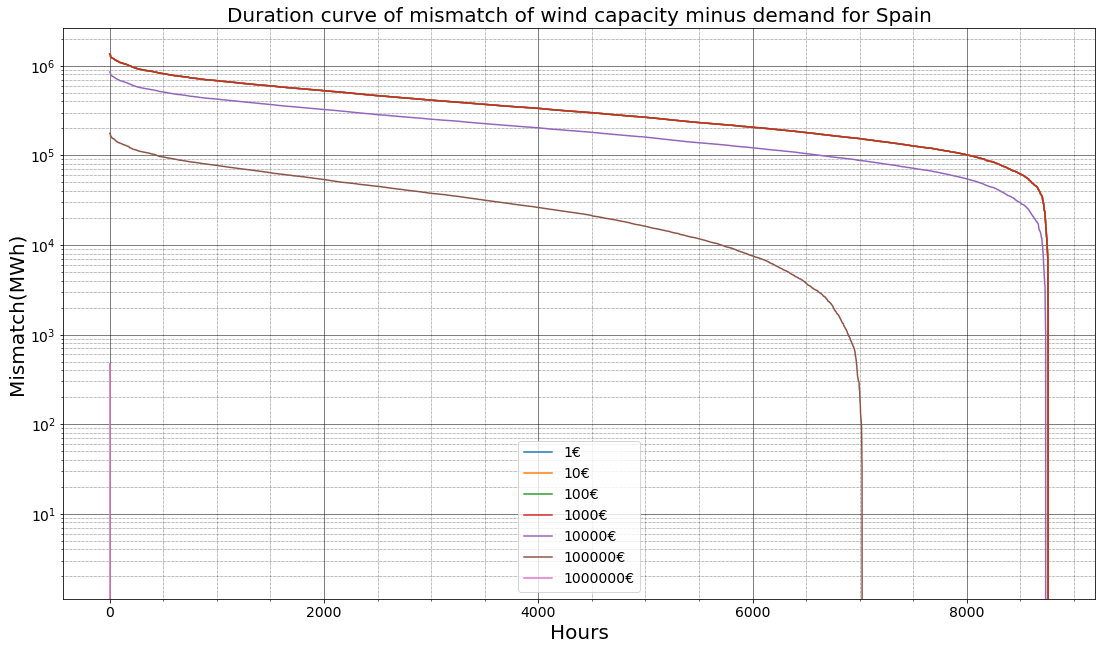

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m4mm4ciz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x1391d05a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61304 rows and 26274 columns
Presolve time: 0.05s
Presolved: 16 rows, 10 columns, 32 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.400e+01
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal  

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u3_0gh5a.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x929253ae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61180 rows and 26190 columns
Presolve time: 0.06s
Presolved: 140 rows, 94 columns, 301 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 2.100e+02
 Factor NZ  : 6.640e+02
 Factor Ops : 3.360e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-smgh_uua.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa28e8d57
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 50792 rows and 18932 columns
Presolve time: 0.07s
Presolved: 10528 rows, 7352 columns, 23141 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.579e+04
 Factor NZ  : 5.353e+04 (roughly 8 MBytes of memory)
 Factor Ops : 2.901e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l7ejew9v.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5592e754
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.32e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-orzv1lz5.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe85a457b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wa8_zpgp.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01efc3b9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ps20qcgn.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xffeeac60
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10


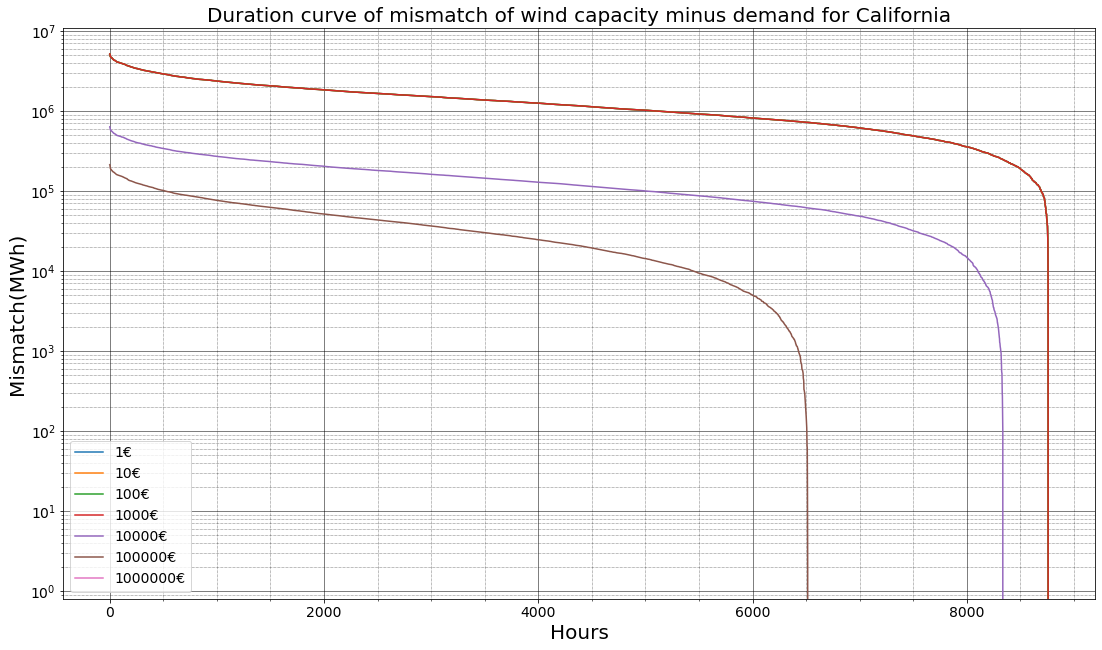

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-etv85qxr.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x63de72d7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-02, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61222 rows and 26233 columns
Presolve time: 0.05s
Presolved: 98 rows, 51 columns, 196 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.470e+02
 Factor NZ  : 3.460e+02
 Factor Ops : 1.230e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lyxmzke3.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd9879d12
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 60814 rows and 25919 columns
Presolve time: 0.06s
Presolved: 506 rows, 365 columns, 1121 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.590e+02
 Factor NZ  : 2.649e+03
 Factor Ops : 1.462e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i01o4j6y.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xf9dbe476
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 53042 rows and 20342 columns
Presolve time: 0.06s
Presolved: 8278 rows, 5942 columns, 18356 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.242e+04
 Factor NZ  : 4.338e+04 (roughly 6 MBytes of memory)
 Factor Ops : 2.403e+05 (less than 1 second per iteration)
 Threads    : 1

                  O

INFO:pypsa.linopf:Optimization successful. Objective value: 3.58e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pfz4cxm4.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xc2d0ceb8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.47e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s3wnsa7_.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x53916585
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.92e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fdoownuj.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7a118f74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.37s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6svvc1qf.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xafabafae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+09


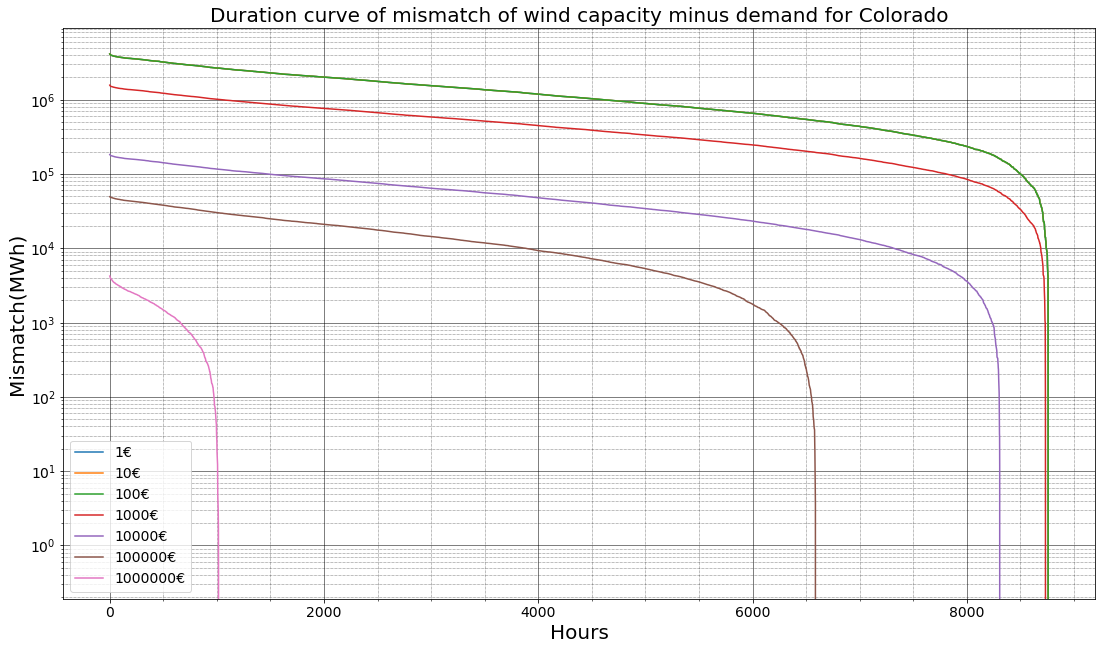

In [171]:
def wind_same_region_mismatch(n, powers):
    plotrange = np.logspace(0, powers, powers+1)
    mismatches = pd.DataFrame()
    for number in plotrange:
        mismatches[str(int(number))+'EUR'] = find_wind_mismatch(n, number)['wind mismatch']
    for col in mismatches.columns:
        mismatches[col] = mismatches[col].sort_values(ascending = False).values
    return mismatches




def make_regional_wind_fig(n, powers):
    df = wind_same_region_mismatch(n, powers)
    fig, ax = plt.subplots()
    plt.plot(df.index, df[list(df.columns.values)])

    ax.minorticks_on()

    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set_title("Duration curve of mismatch of wind capacity minus demand for "+ network_names[mynetworks.index(n)], size = '20')
    ax.set_xlabel("Hours", fontsize = 20)
    ax.set_ylabel("Mismatch(MWh)", fontsize = 20)
    ax.set_yscale('log')
    
    myrange = np.logspace(0, powers, powers+1)
    mystrings = [str(int(x))+ "€" for x in myrange]
    
    plt.legend(mystrings, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    fig = plt.gcf()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(18.5, 10.5)
    
    plt.savefig("Images/WindRegionalMismatchDurationCurve"+network_names[mynetworks.index(n)]+"LogScale")
    plt.show()
    return

for n in mynetworks:
    make_regional_wind_fig(n, 6)